# RESOLVE 学習データの生成とDNNモデルの構築

In [1]:
%pwd

'/Users/quetzal/GL/geophysics/Repos/DLXEM/environment/base'

## 1.1 データ生成

- import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from tensorflow.keras.models import load_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

sys.path.append('../../')
from dlxem import emexecutor as em
from dlxem import networks, forward

- settings

In [3]:
### SETTINGS ##########################
# 層厚を決める

thicks1 = np.hstack([[0.1]*10, [1.]*9, [10.]*9, [100]])

thicks2 = np.hstack([[5], [.5]*10, [5.]*18, [100]*2])

depth_max = 150
depth_init = 1
layers = 30

depth3 = np.logspace(np.log10(depth_init), np.log10(depth_max), layers-1)
depth3 = np.append([0], depth3)
thicks3 = []
for i in range(layers-1):
    thicks3.append(depth3[i+1]-depth3[i])

# 上から選ぶ or 自由に設定
thicks = thicks2

In [4]:
# データ生成の設定
size = 40000
parallel_num = 8
config = {
    'thicks' : thicks,
    'height_range' : (15, 75),
    'freqs' : [382, 1822, 7970, 35920, 130100],
    'span' : 7.86,
    'to_ppm' : True,
    'add_noise' : True,
    'noise_level' : [10, 10, 20, 40, 50],
    'random_mode' : 'normal',
}

# 学習の設定
epochs = 200
batch_size = 200

# 保存ファイルの識別名
file_tag = '20210709_resolve03'

In [5]:
dataset_path = 'database/dataset/'
dsetfile_name = dataset_path + file_tag+'{}_{}.csv'.format(size, config['random_mode'])

model_path = 'model/'
histfile_name = model_path + 'history/' + file_tag + 'history.csv'
nnetfile_name = model_path + 'network/' + file_tag + 'network.h5'

freqs = config['freqs']
span = config['span']
noised = config['add_noise']
to_ppm = config['to_ppm']

- run

In [6]:
if os.path.exists(dsetfile_name):
    print('Datasets already exist')
else:
    resolve = em.Resolve1D(**config)
    data = resolve.multi_process(size, parallel_num)

    df = pd.DataFrame(data)
    df.to_csv(dsetfile_name, header=None, index=False)
    print("-> /" + dsetfile_name)

-> /database/dataset/20210709_resolve0340000_normal.csv


## 1.2 モデル学習

In [7]:
#全体読み込み
df = pd.read_csv(dsetfile_name, header=None)

#分割
x = df.iloc[:, :11].values
y = df.iloc[:, 11:].values
y = np.log10(y)
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.02, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=0)
x_test_org = x_test.copy()
#x正規化
sc = preprocessing.StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

In [28]:
if os.path.exists(nnetfile_name):
    print('The Specified Neural Network Model Already Exists.')
    network = load_model(nnetfile_name)
    hist_df = pd.read_csv(histfile_name)
else:
    input_dim = x.shape[1]
    output_dim = y.shape[1]
    network = networks.get_dnn(input_dim, output_dim)
    history = network.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(x_val, y_val))
    network.save(nnetfile_name)
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(histfile_name)


The Specified Neural Network Model Already Exists.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# 評価・テスト

## 学習過程

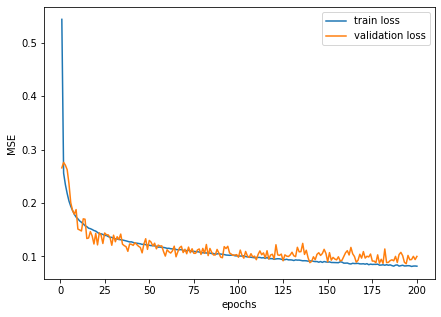

In [9]:
epochs = epochs
epochs = np.arange(1, epochs+1)
val_mse = hist_df['val_loss'].values
loss = hist_df['loss'].values
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.plot(epochs, loss, label='train loss')
ax.plot(epochs, val_mse, label='validation loss')
ax.set_xlabel('epochs')
ax.set_ylabel('MSE')
ax.legend()

# MSE分布と累積度数

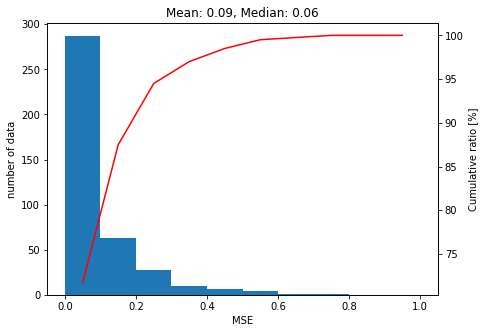

In [10]:
terr = (y_test - network.predict(x_test))**2
res_mse = np.array([k.mean() for k in terr])

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
bins = [.1*(i) for i in range(11)] #適宜調整
n, bins, patches = ax.hist(res_mse, bins=bins)
y2 = np.add.accumulate(n) / n.sum() * 100
x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]
ax.set_xlabel('MSE')
ax.set_ylabel('number of data')
mean = np.mean(res_mse)
median = np.median(res_mse)
ax.set_title('Mean: {mean:.2f}, Median: {median:.2f}'.format(mean=mean, median=median))

# 第2軸のプロット
bx = ax.twinx()
lines = bx.plot(x2, y2, ls='-', color='r', label='Cumulative ratio')
bx.set_ylabel('Cumulative ratio [%]')
print('')

# テスト

345


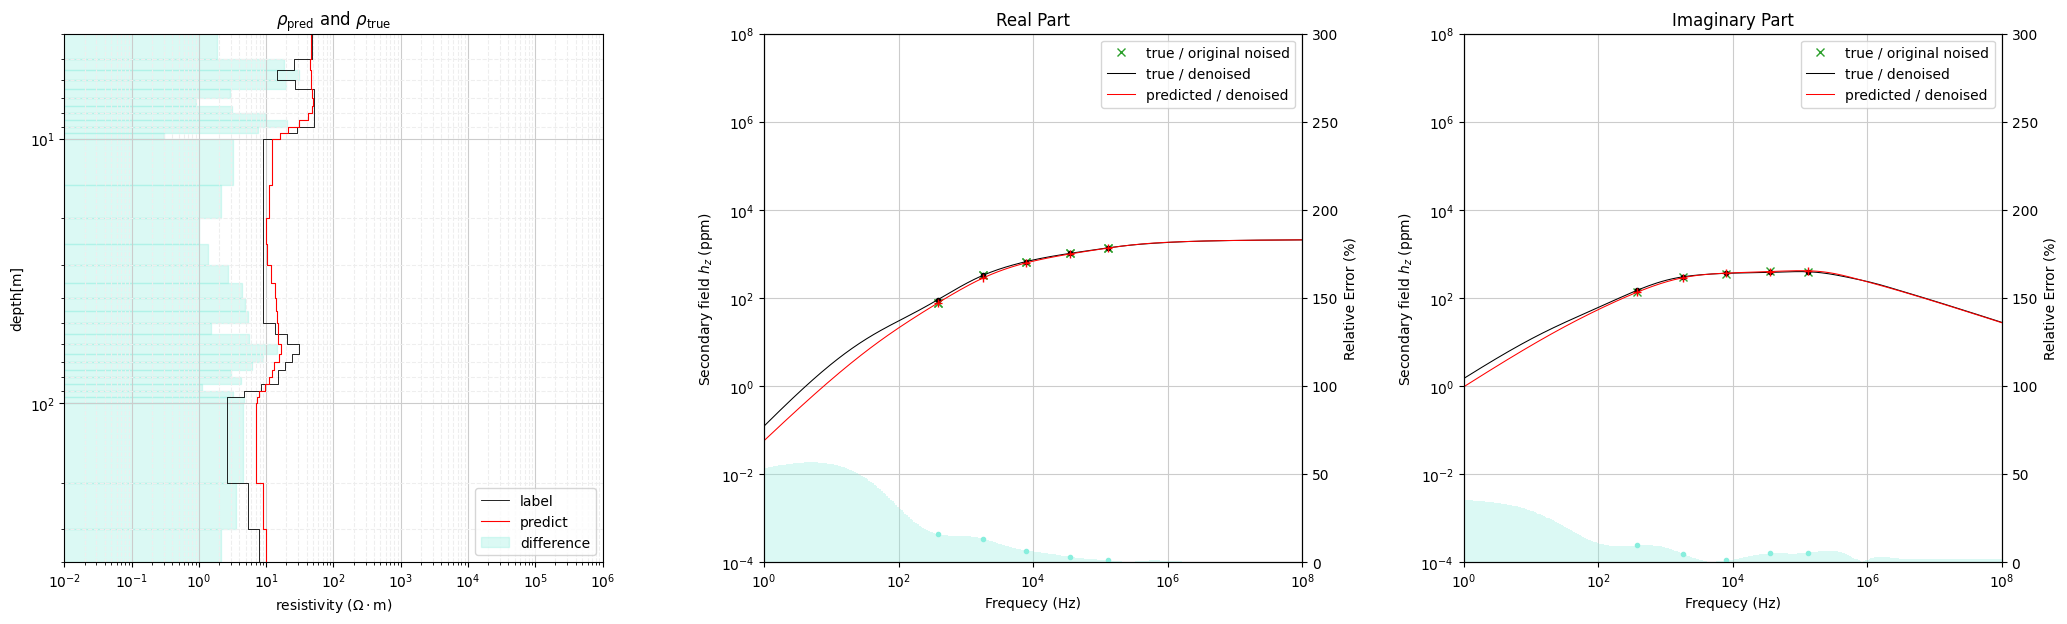

In [27]:
sys.path.append('../../')
from dlxem import myviz as viz

true_res = 10 ** y_test
pred_res = 10 ** network.predict(x_test)
orig_emf = x_test_org[:, :10]
height = x_test_org[:, 10]

test_data_size = len(y_test)
index = np.random.randint(0, test_data_size)

true_res = true_res[index]
pred_res = pred_res[index]
height = height[index]
orig_emf = orig_emf[index]

cfreq_range = (0, 8)
print(index)

fig = viz.resolve.sumplot(thicks, pred_res, true_res, height, span, freqs, cfreq_range, orig_emf, ppm=to_ppm, noised=noised, log_depth=True)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.axes[0].set_yscale('log')

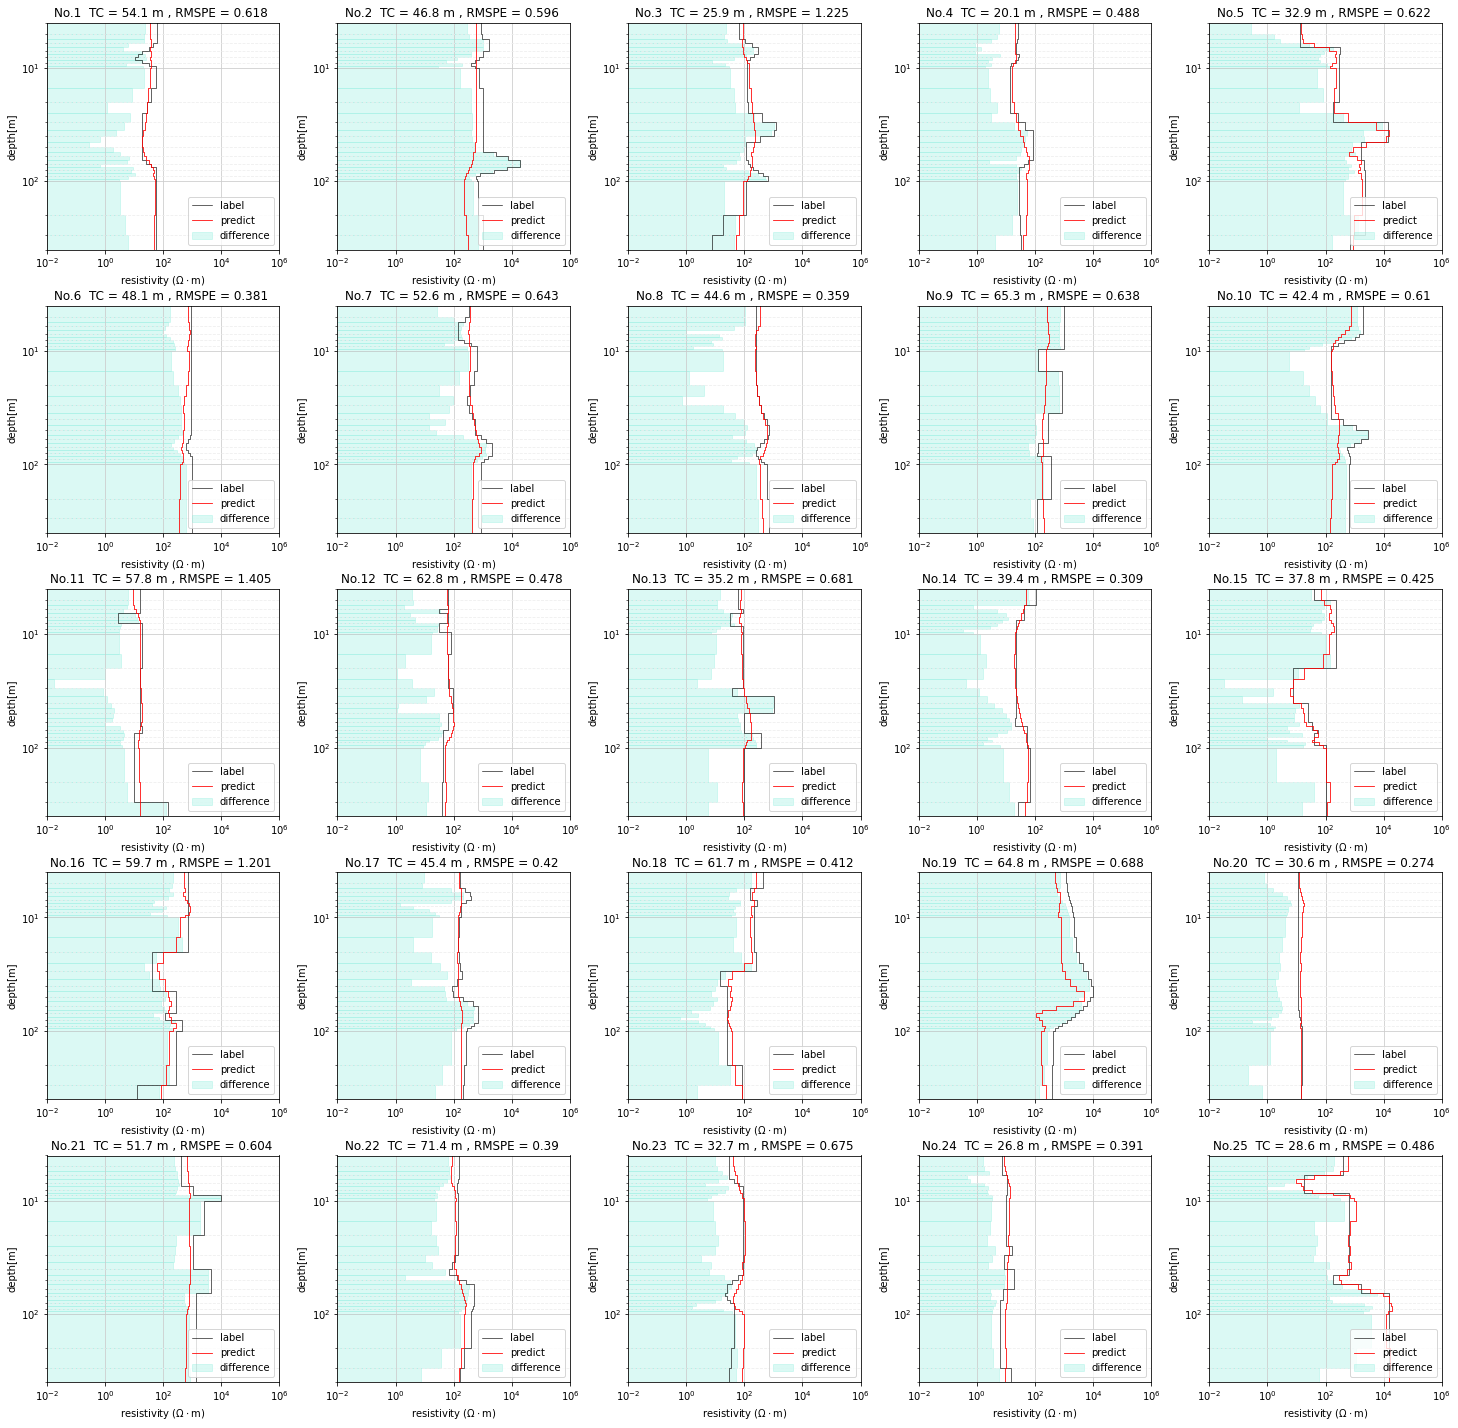

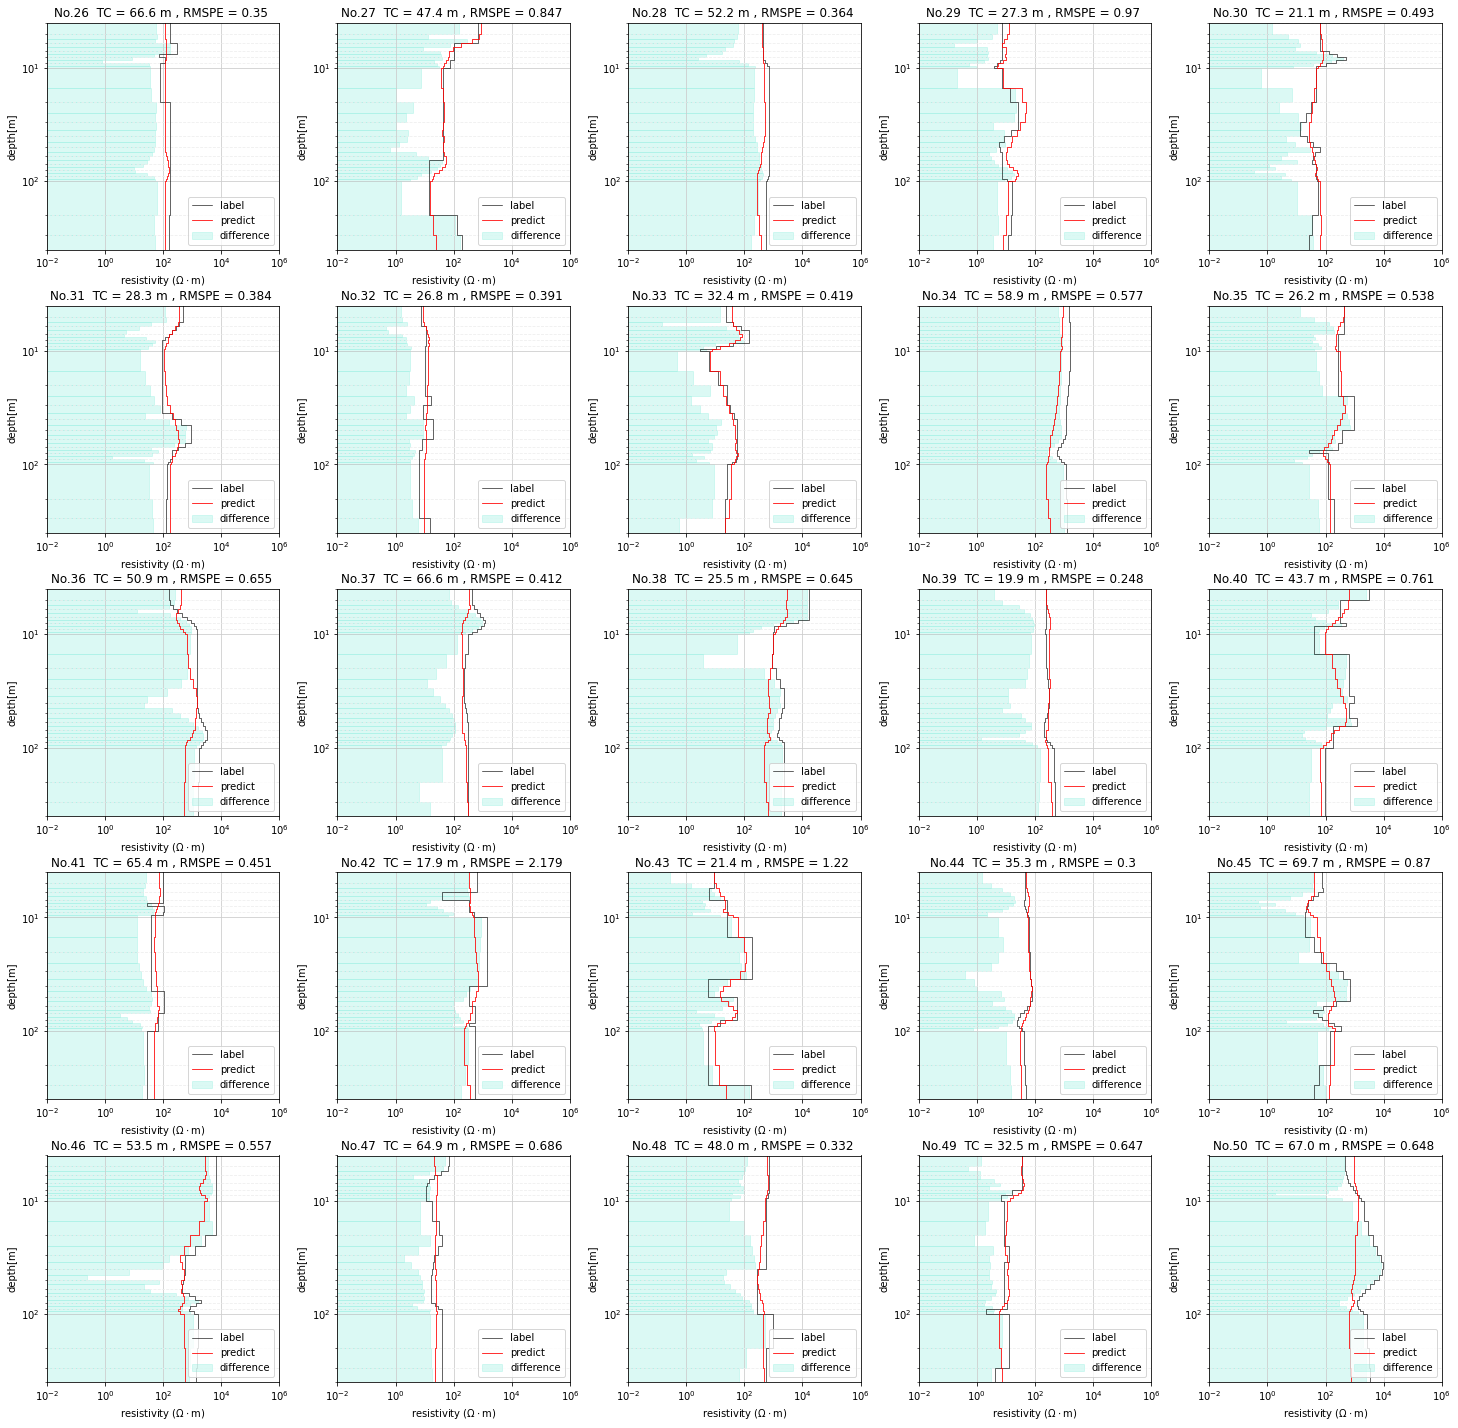

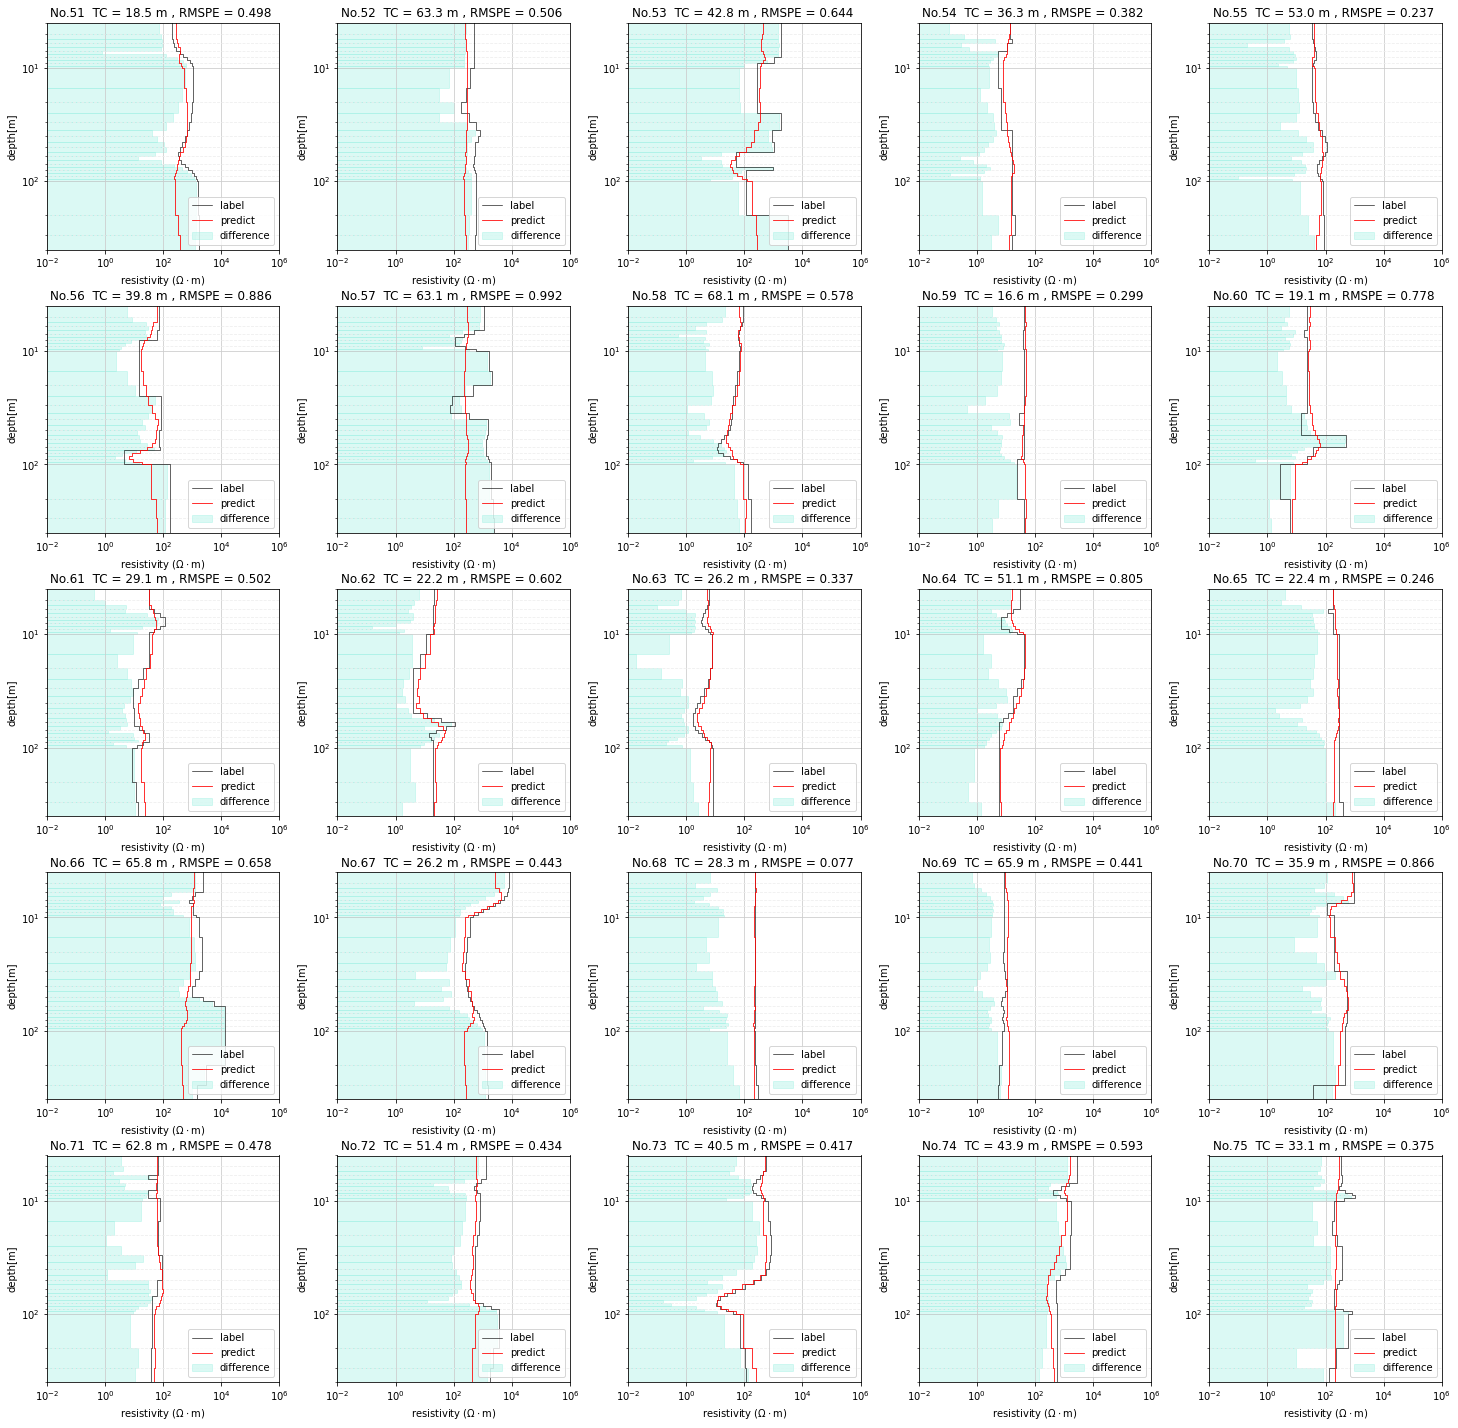

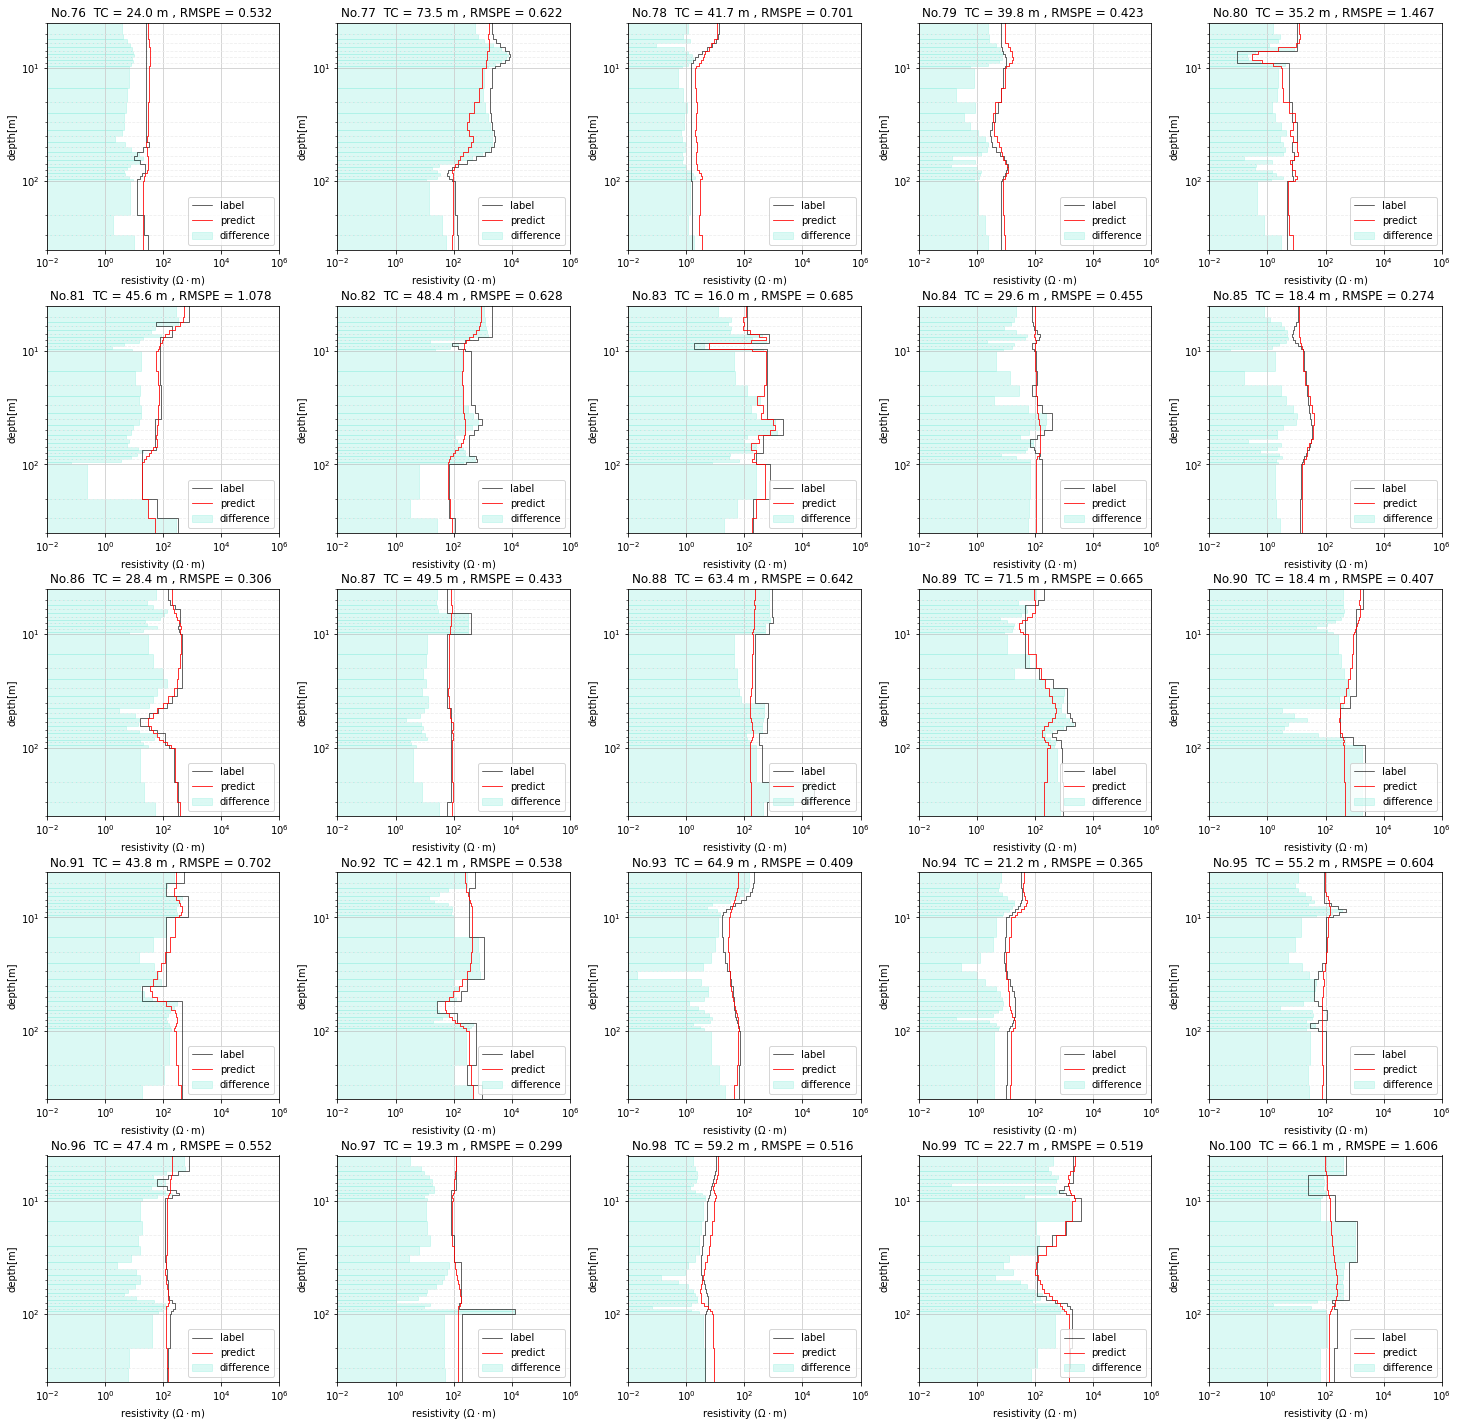

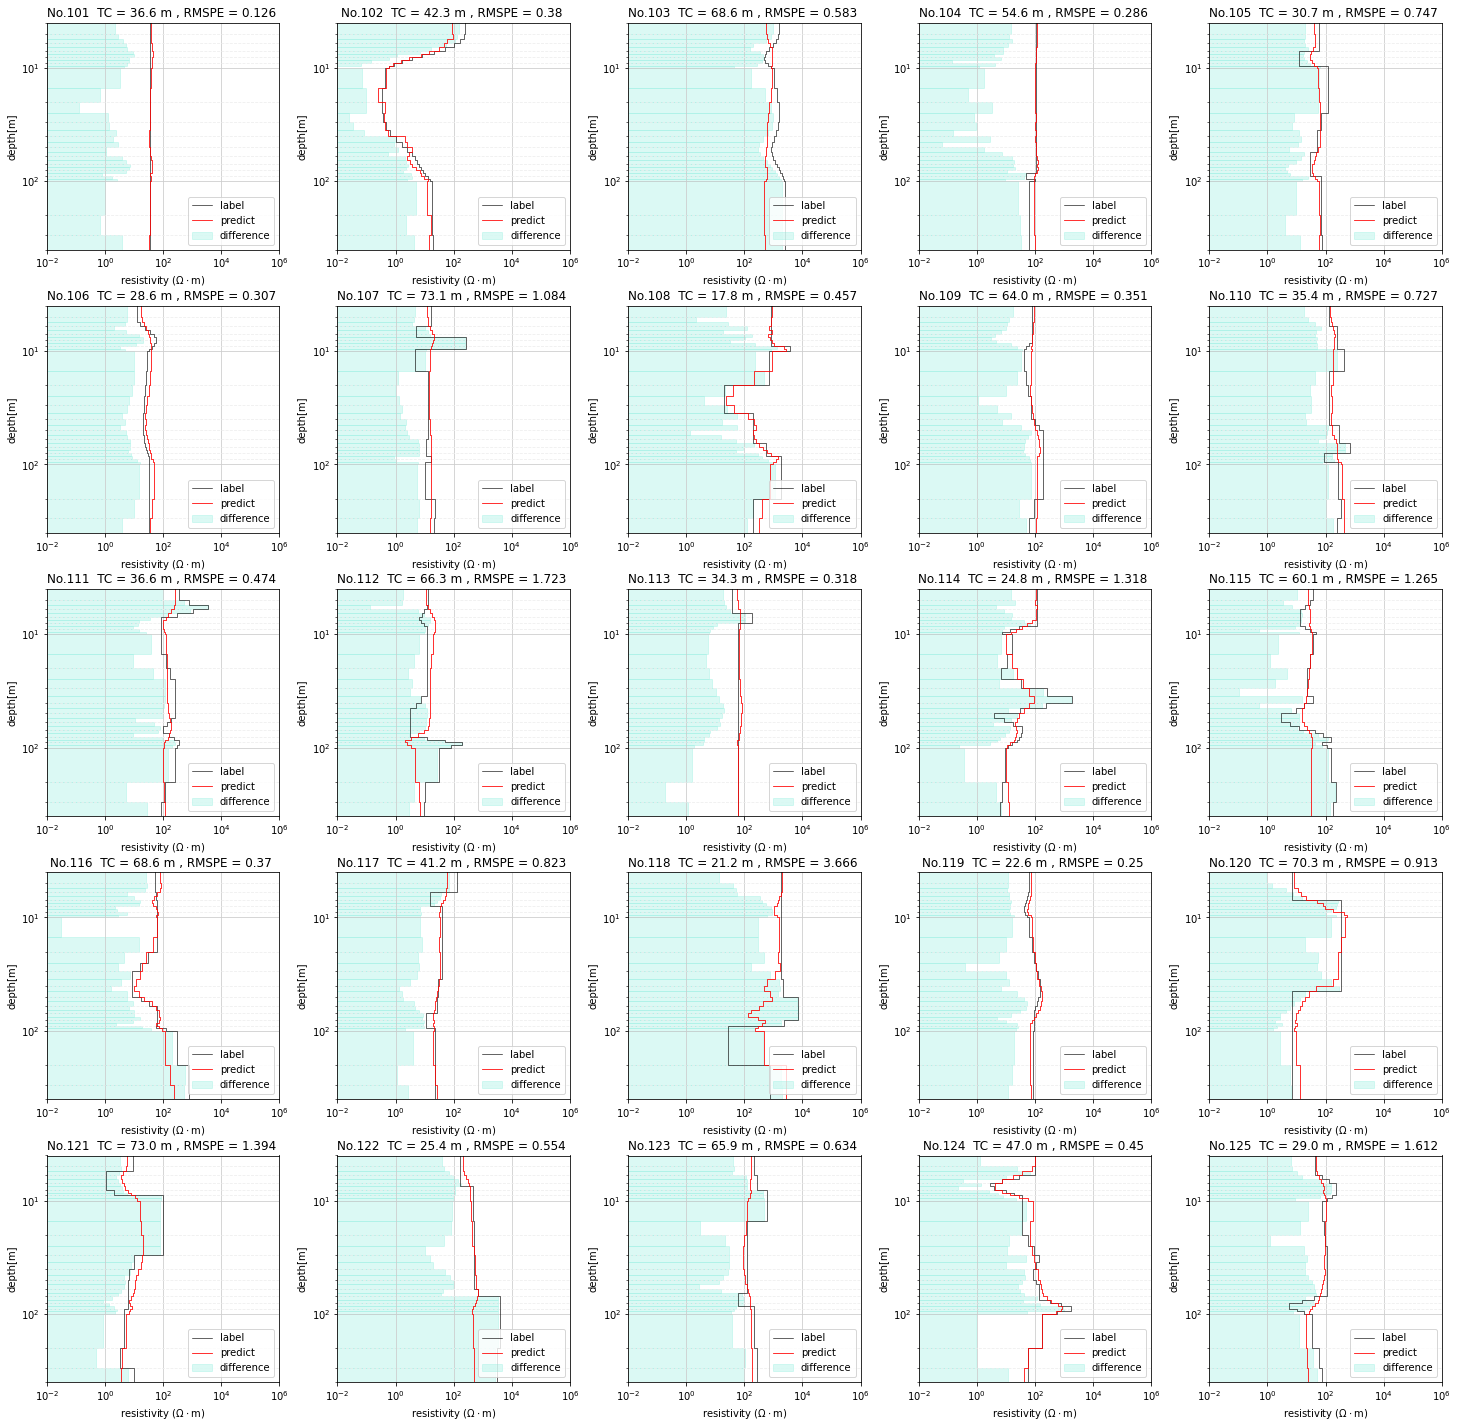

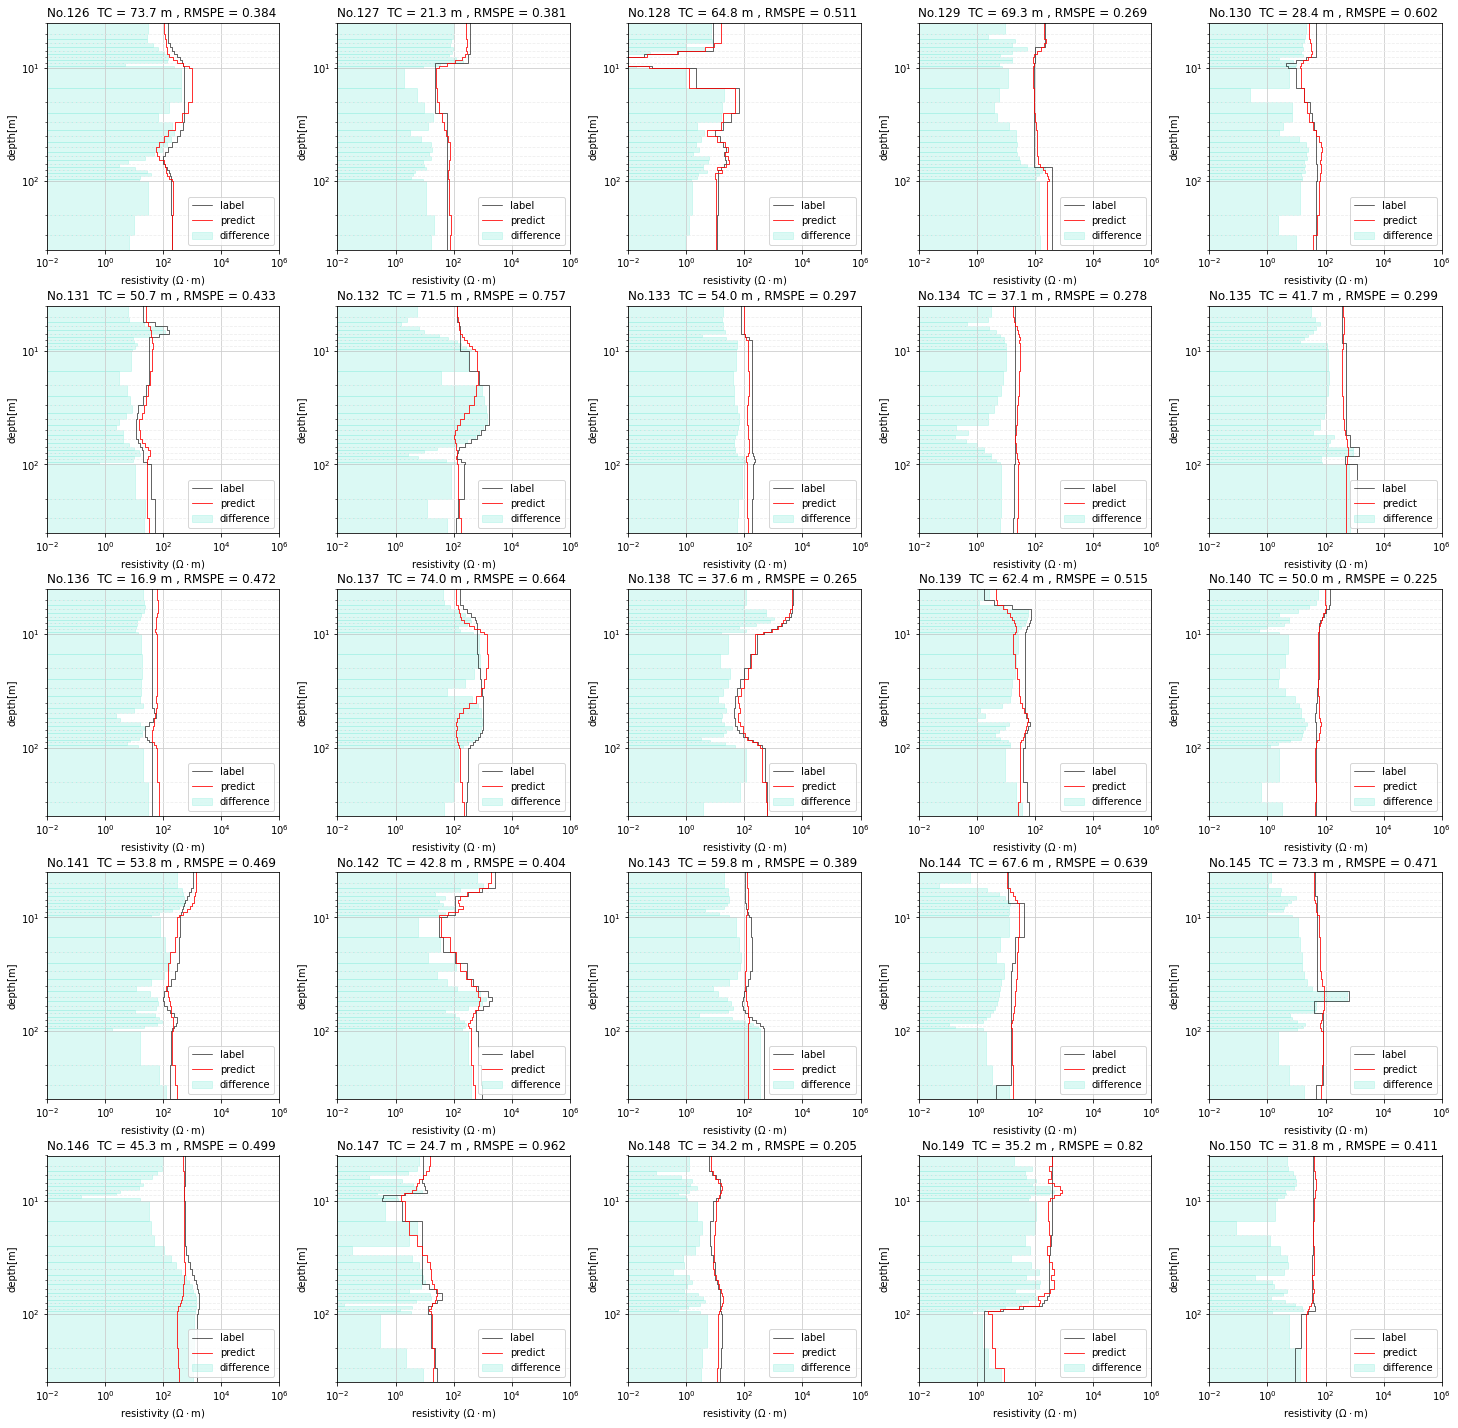

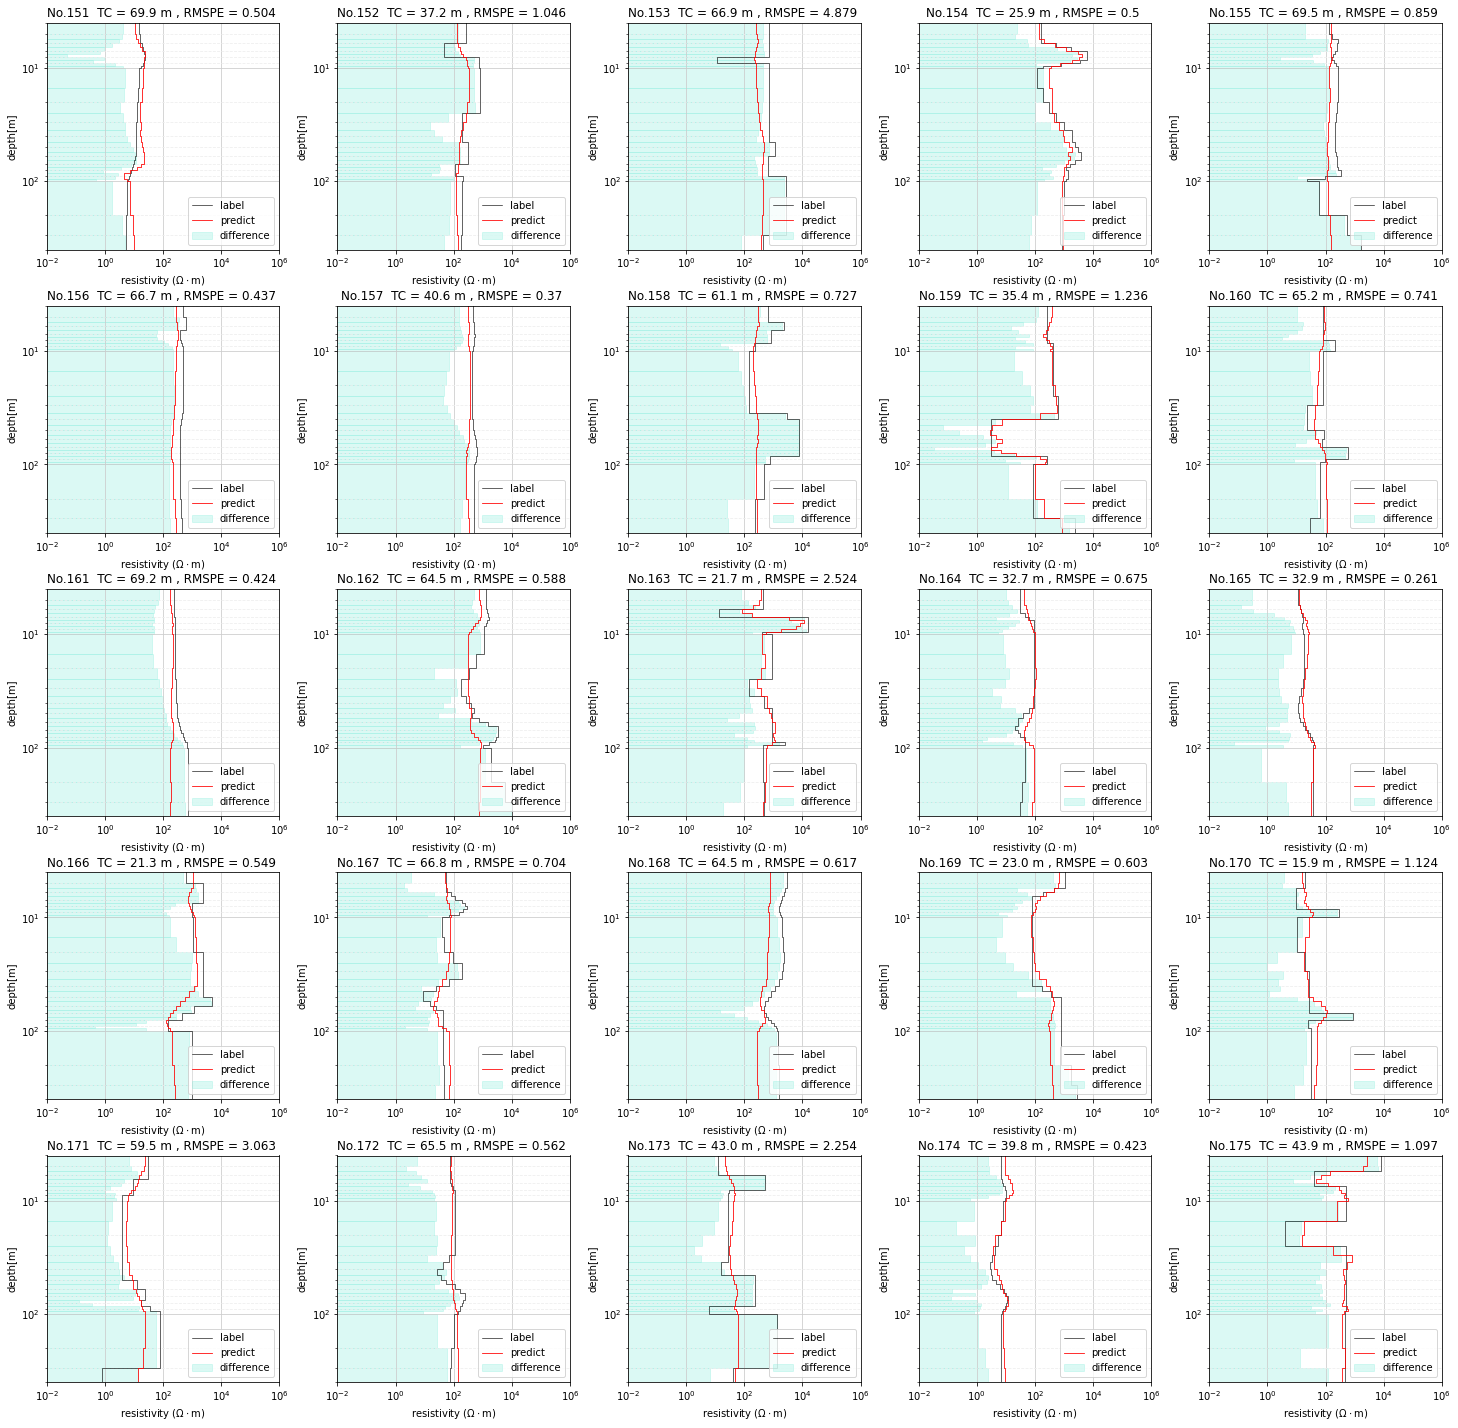

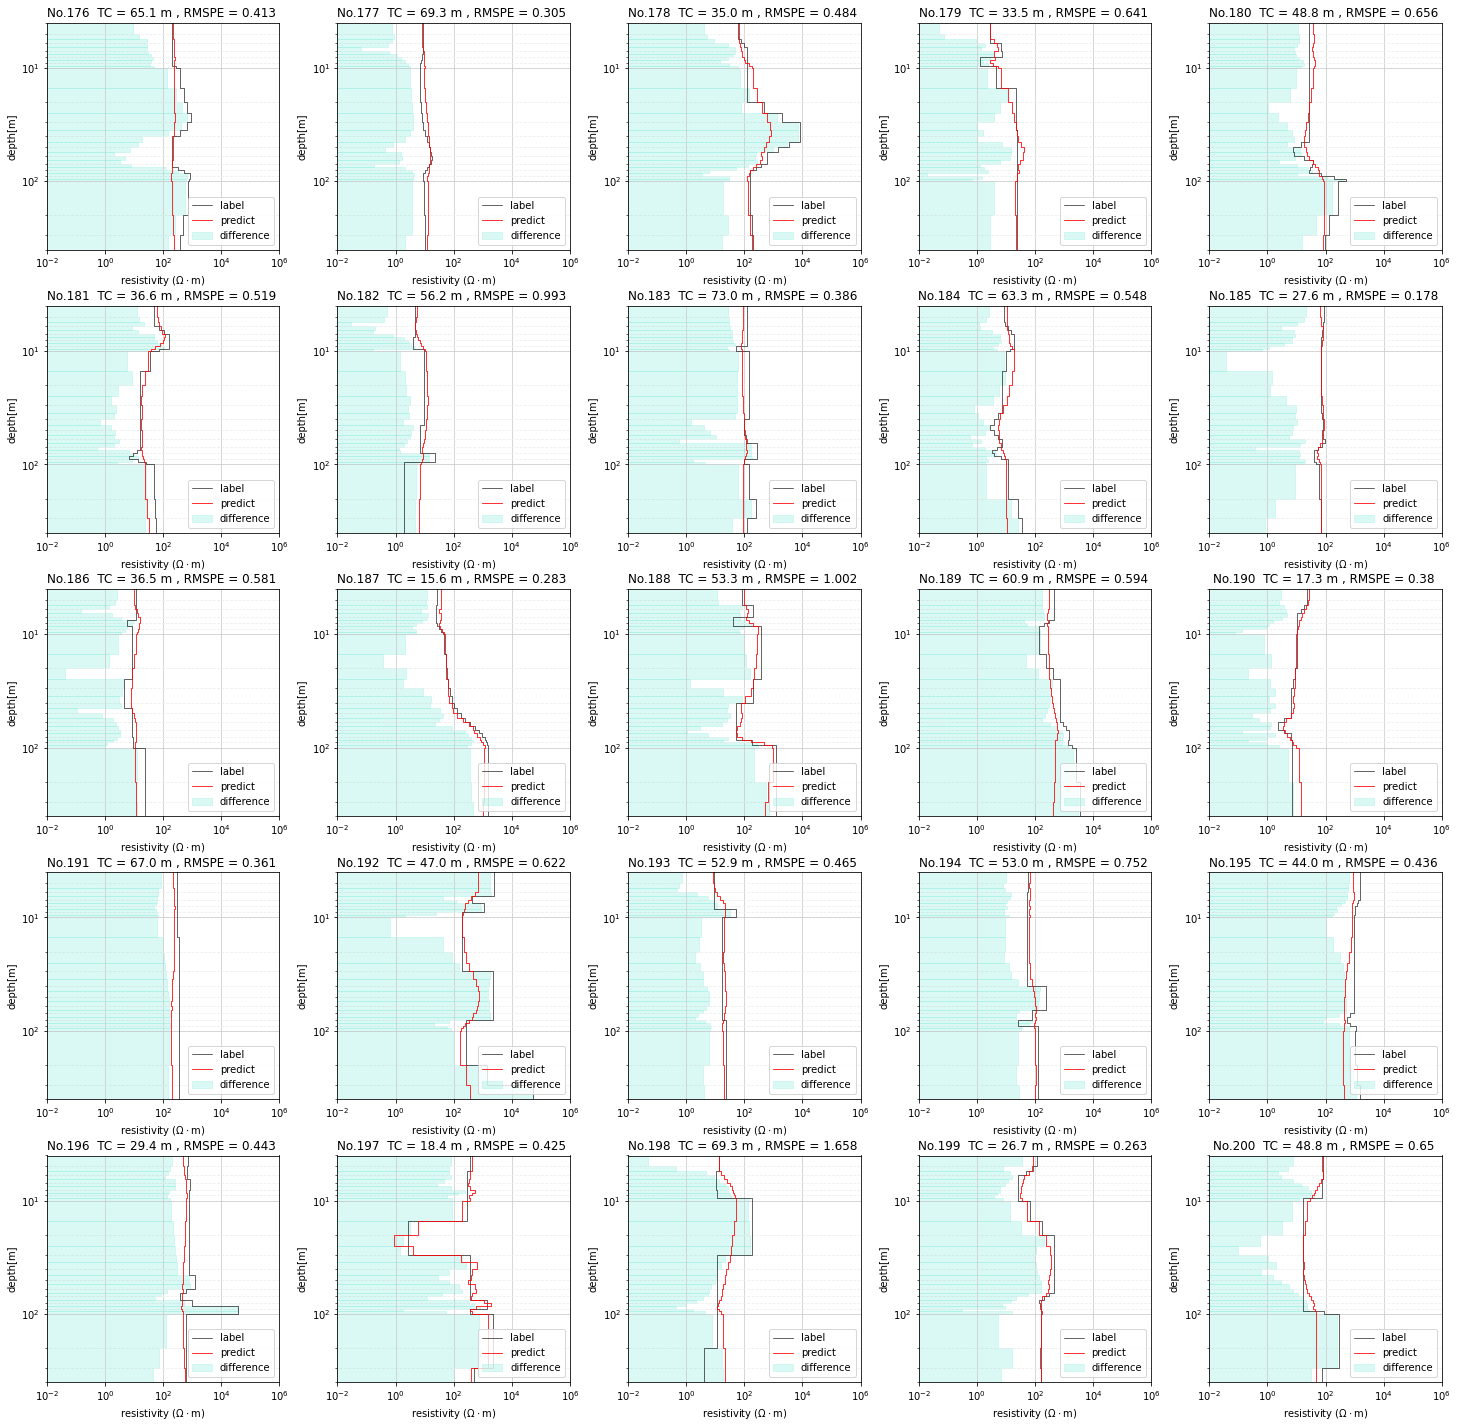

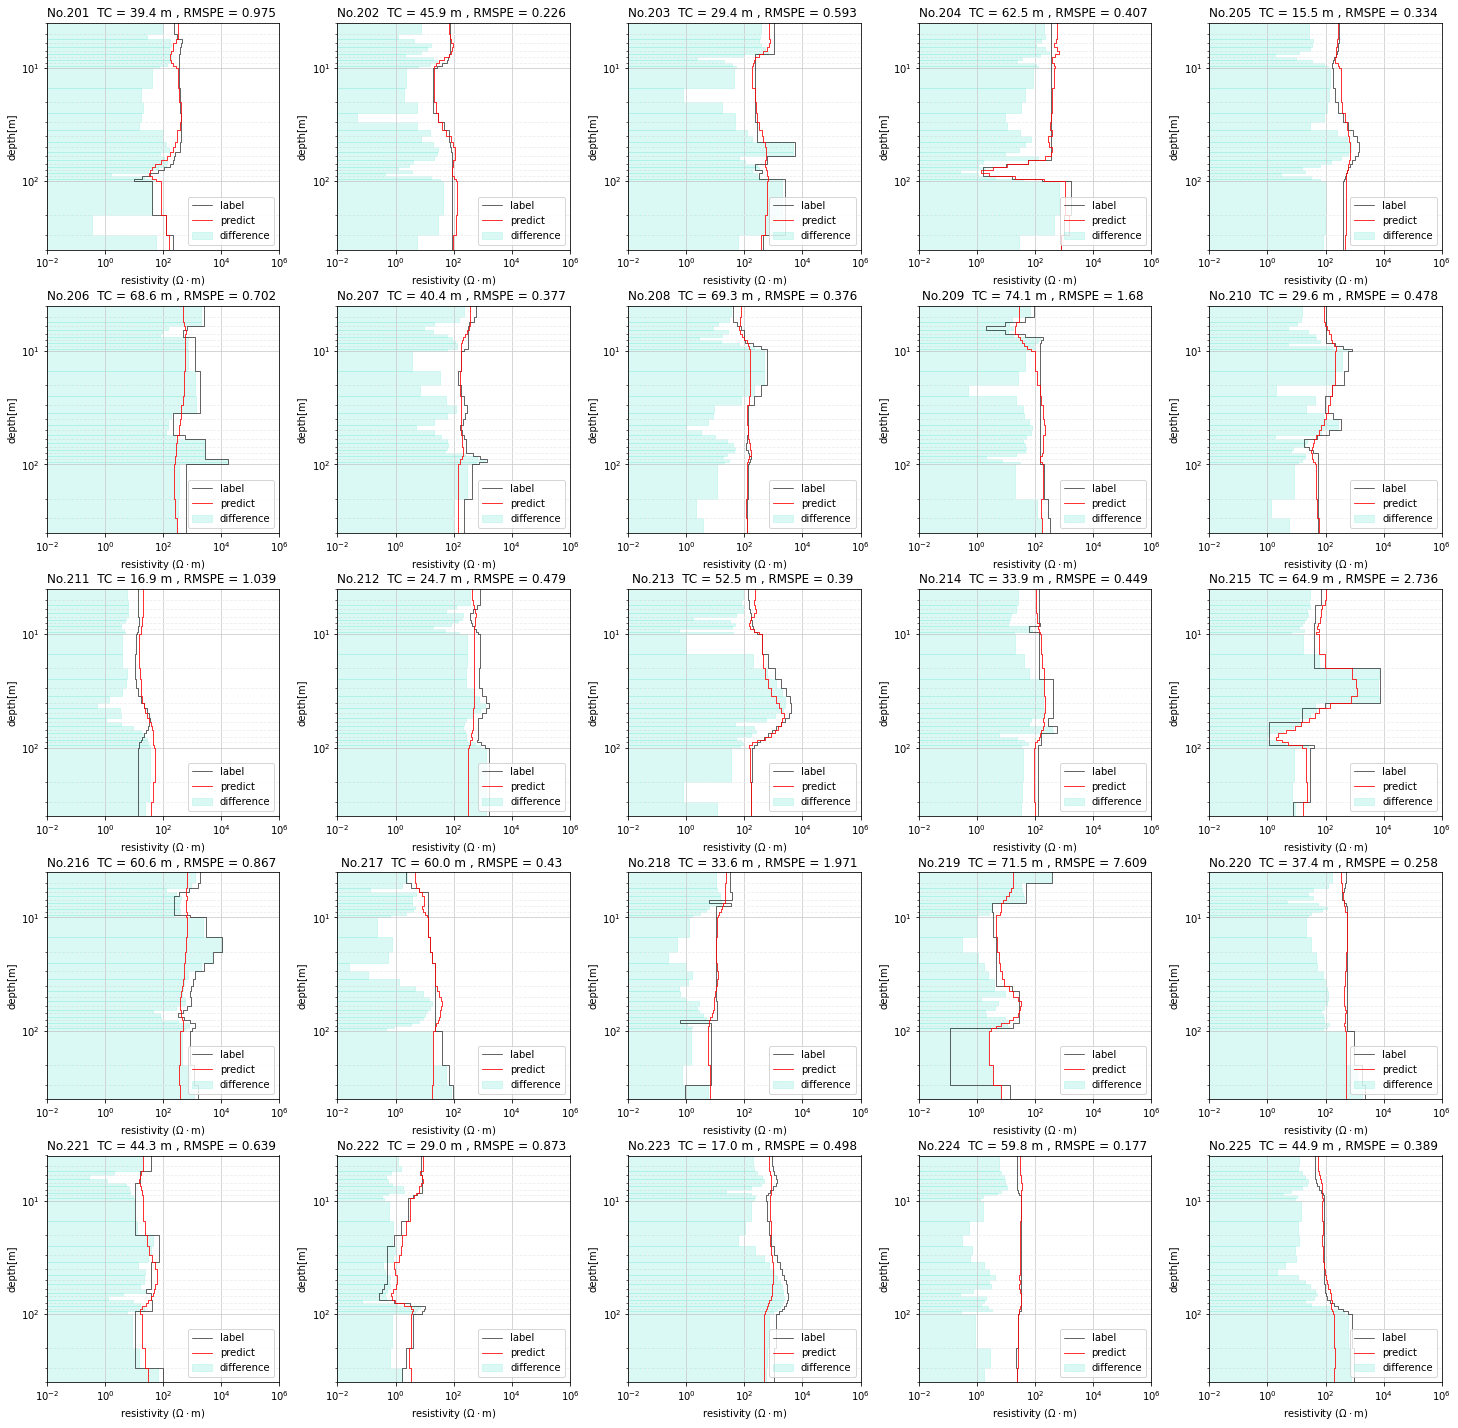

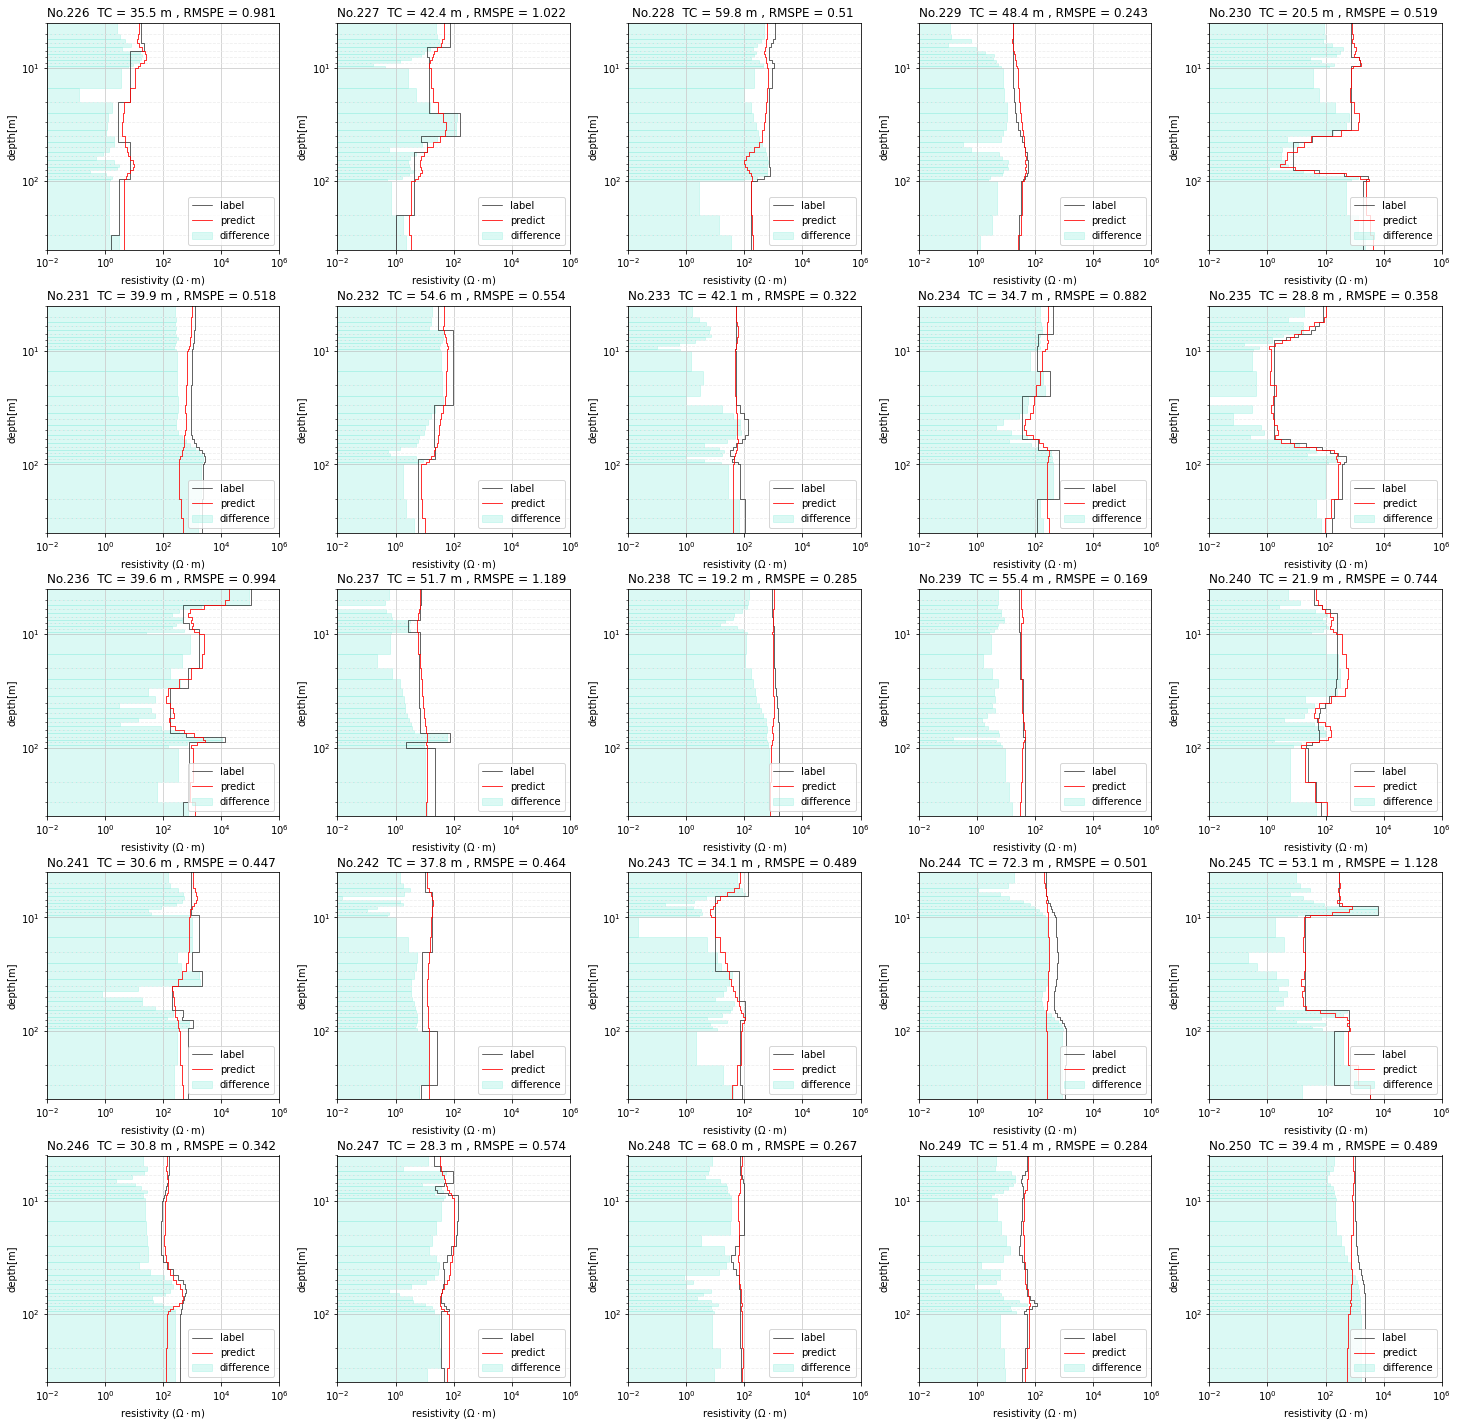

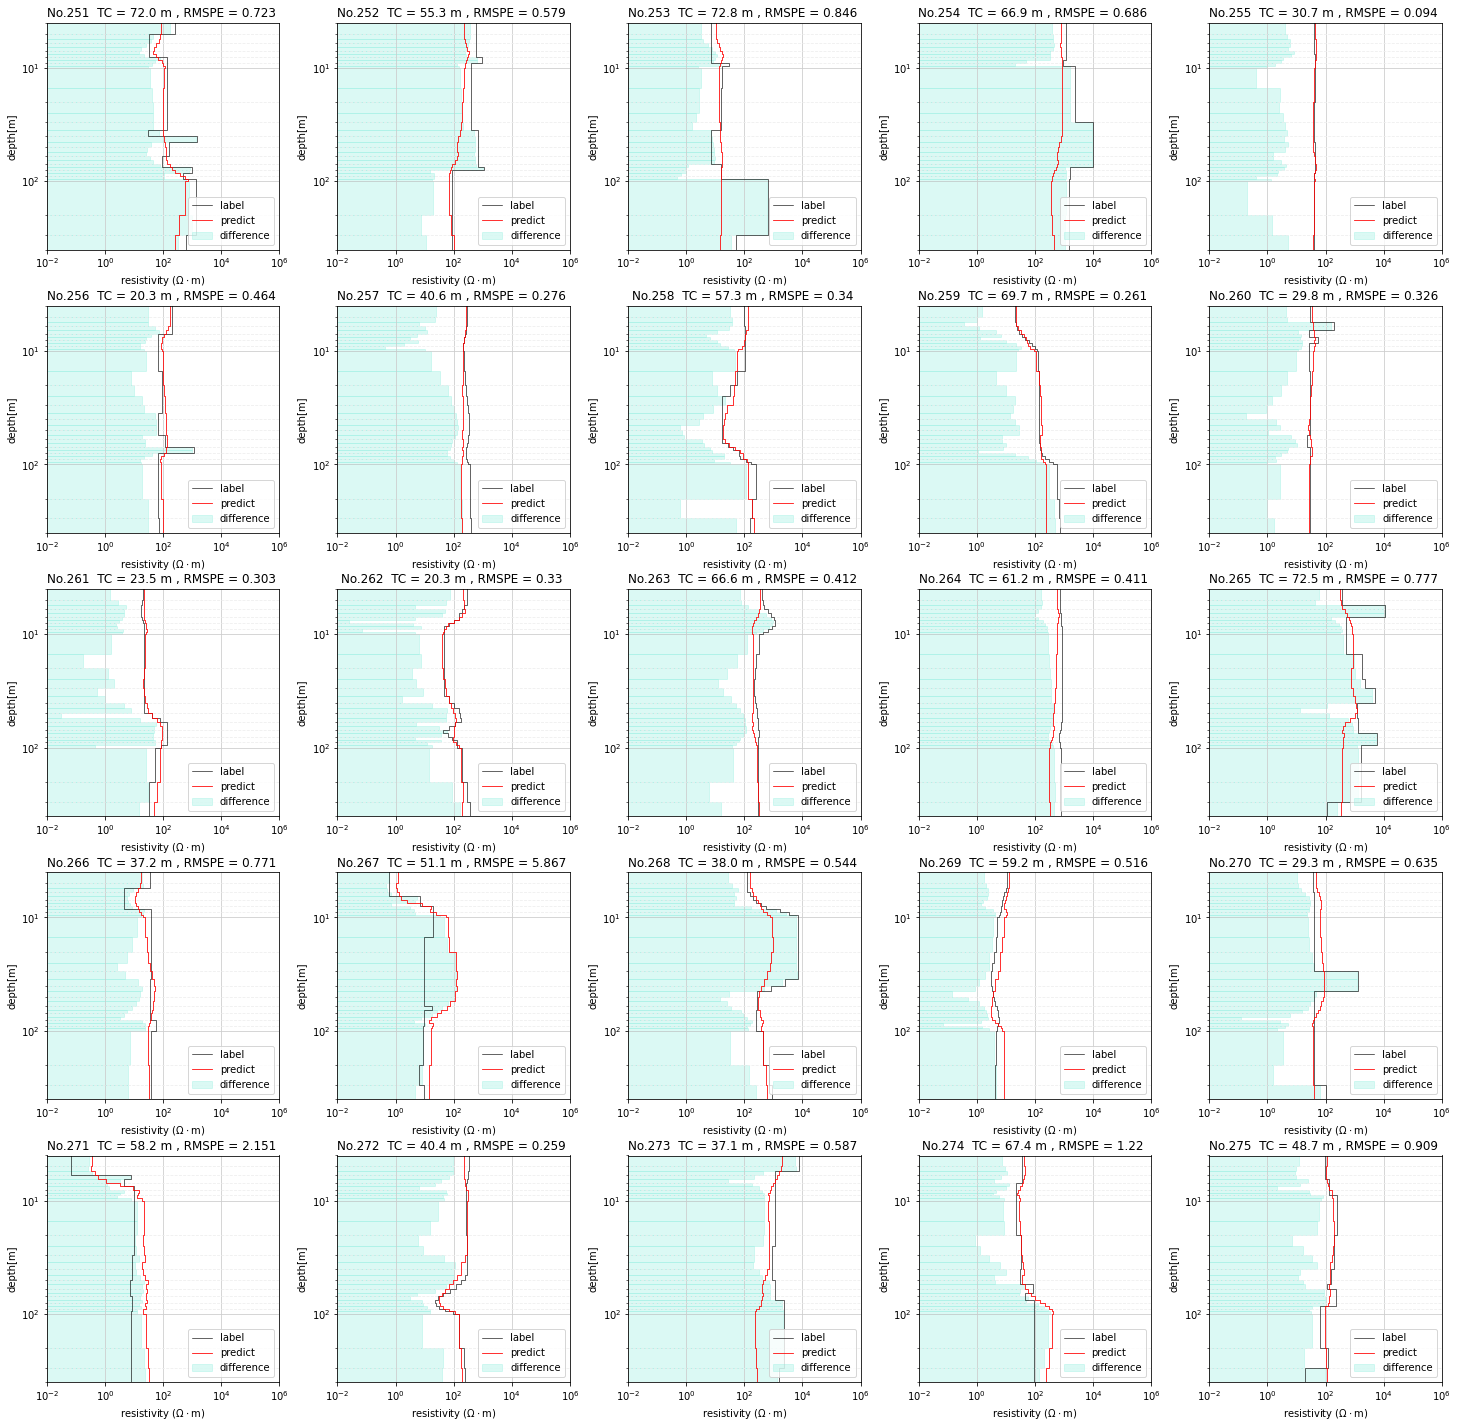

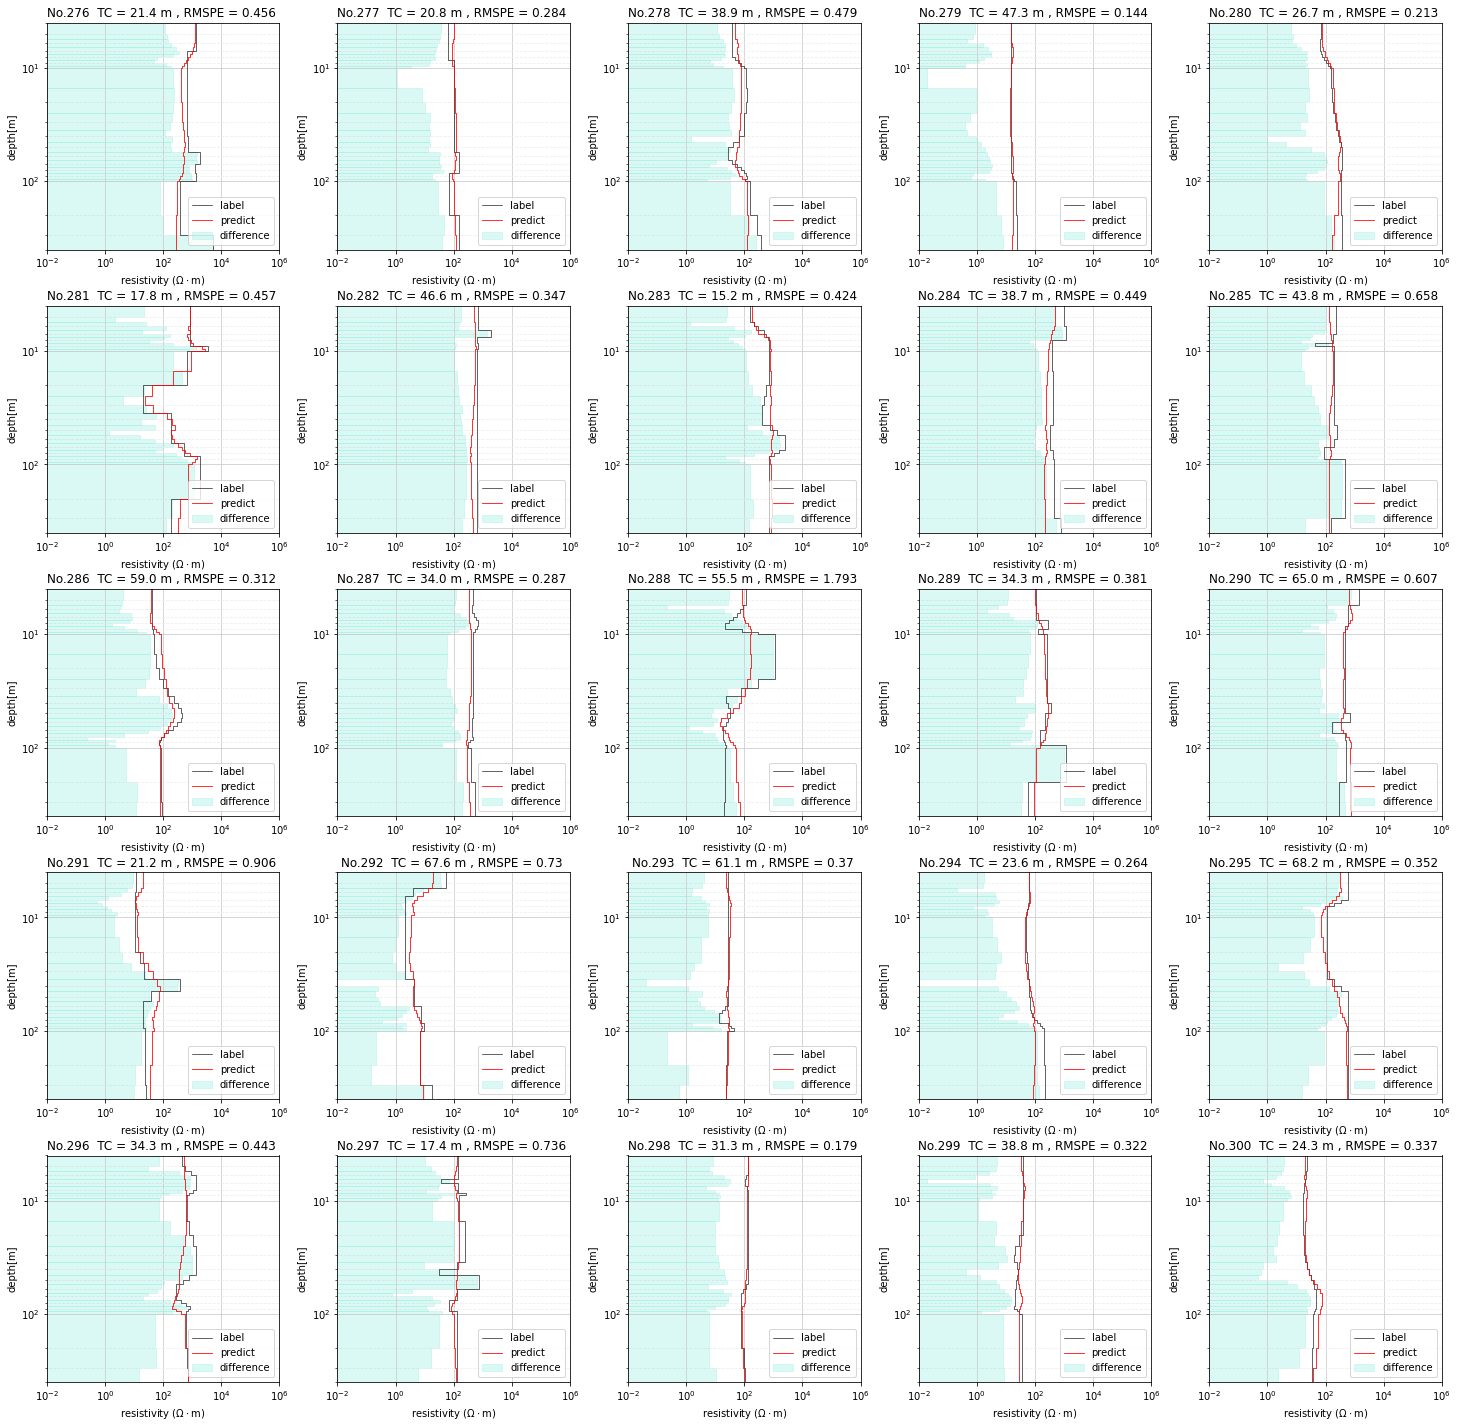

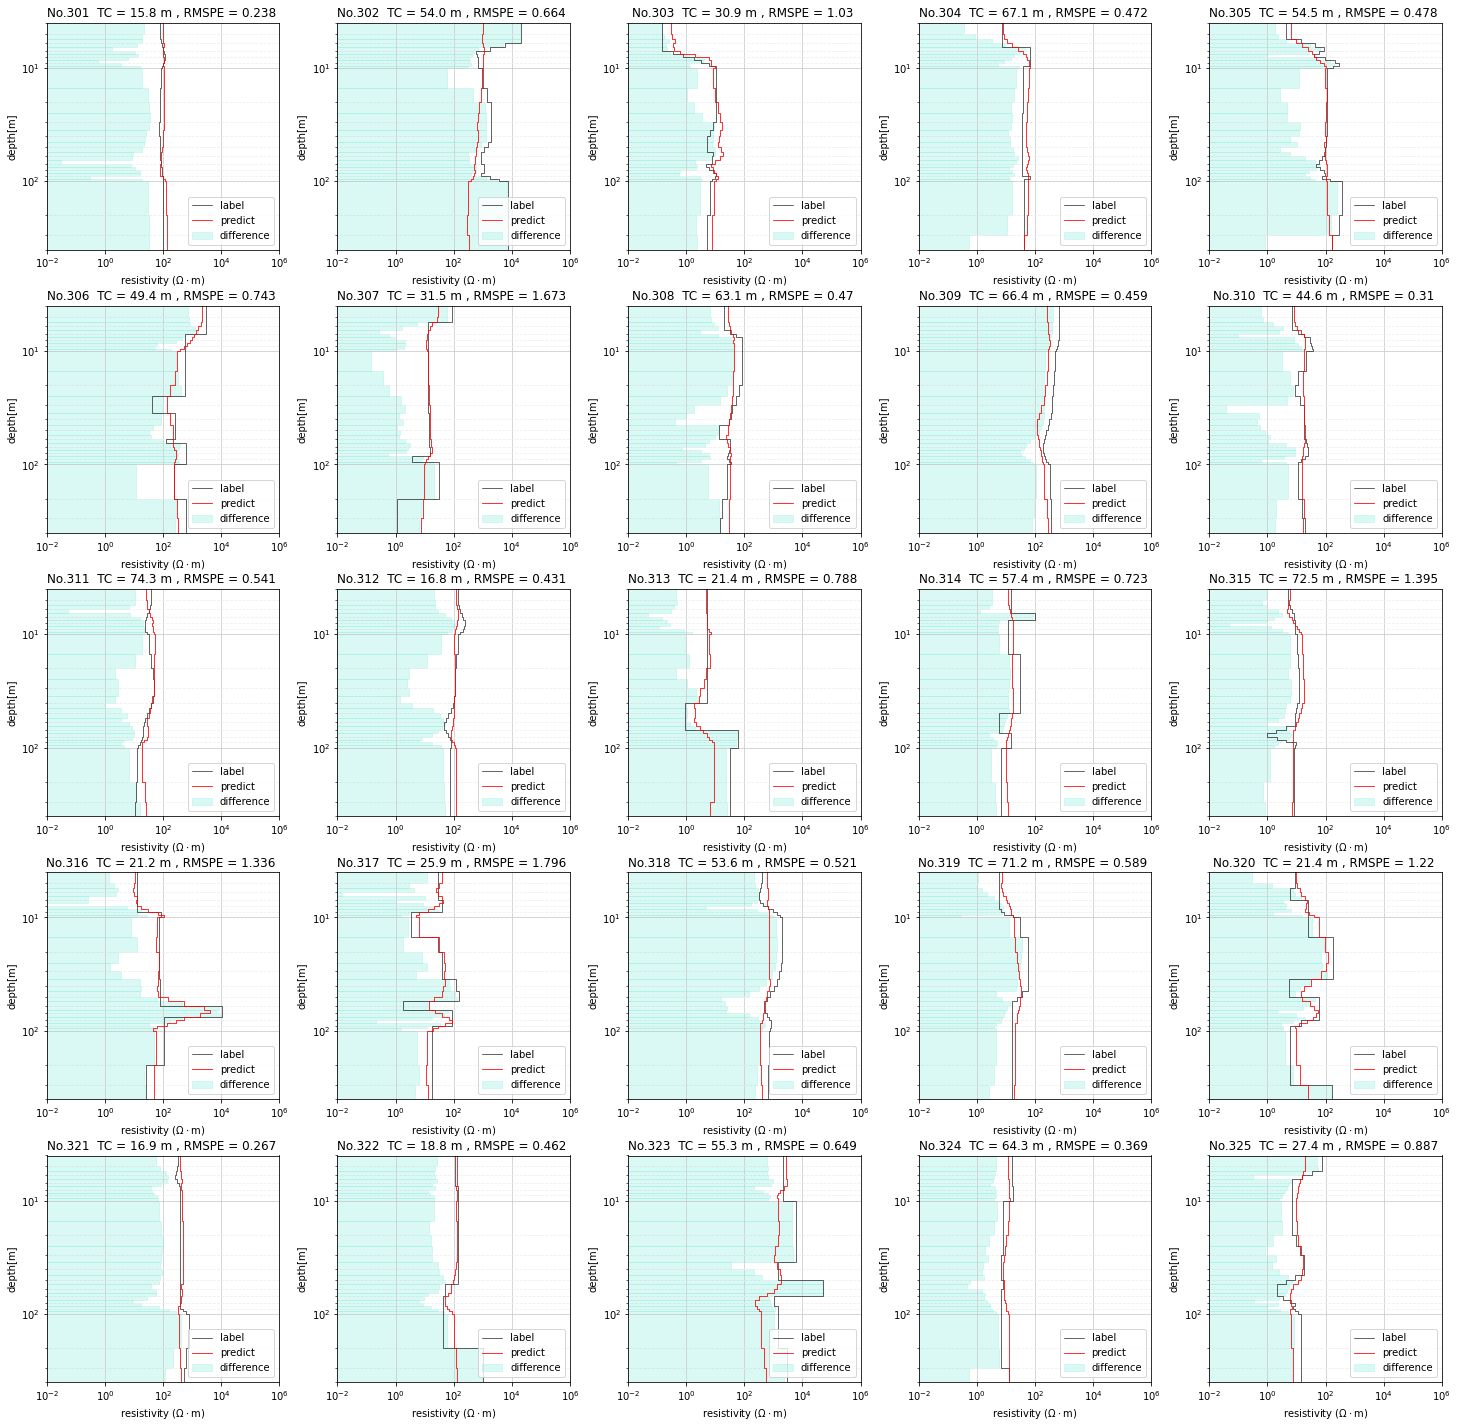

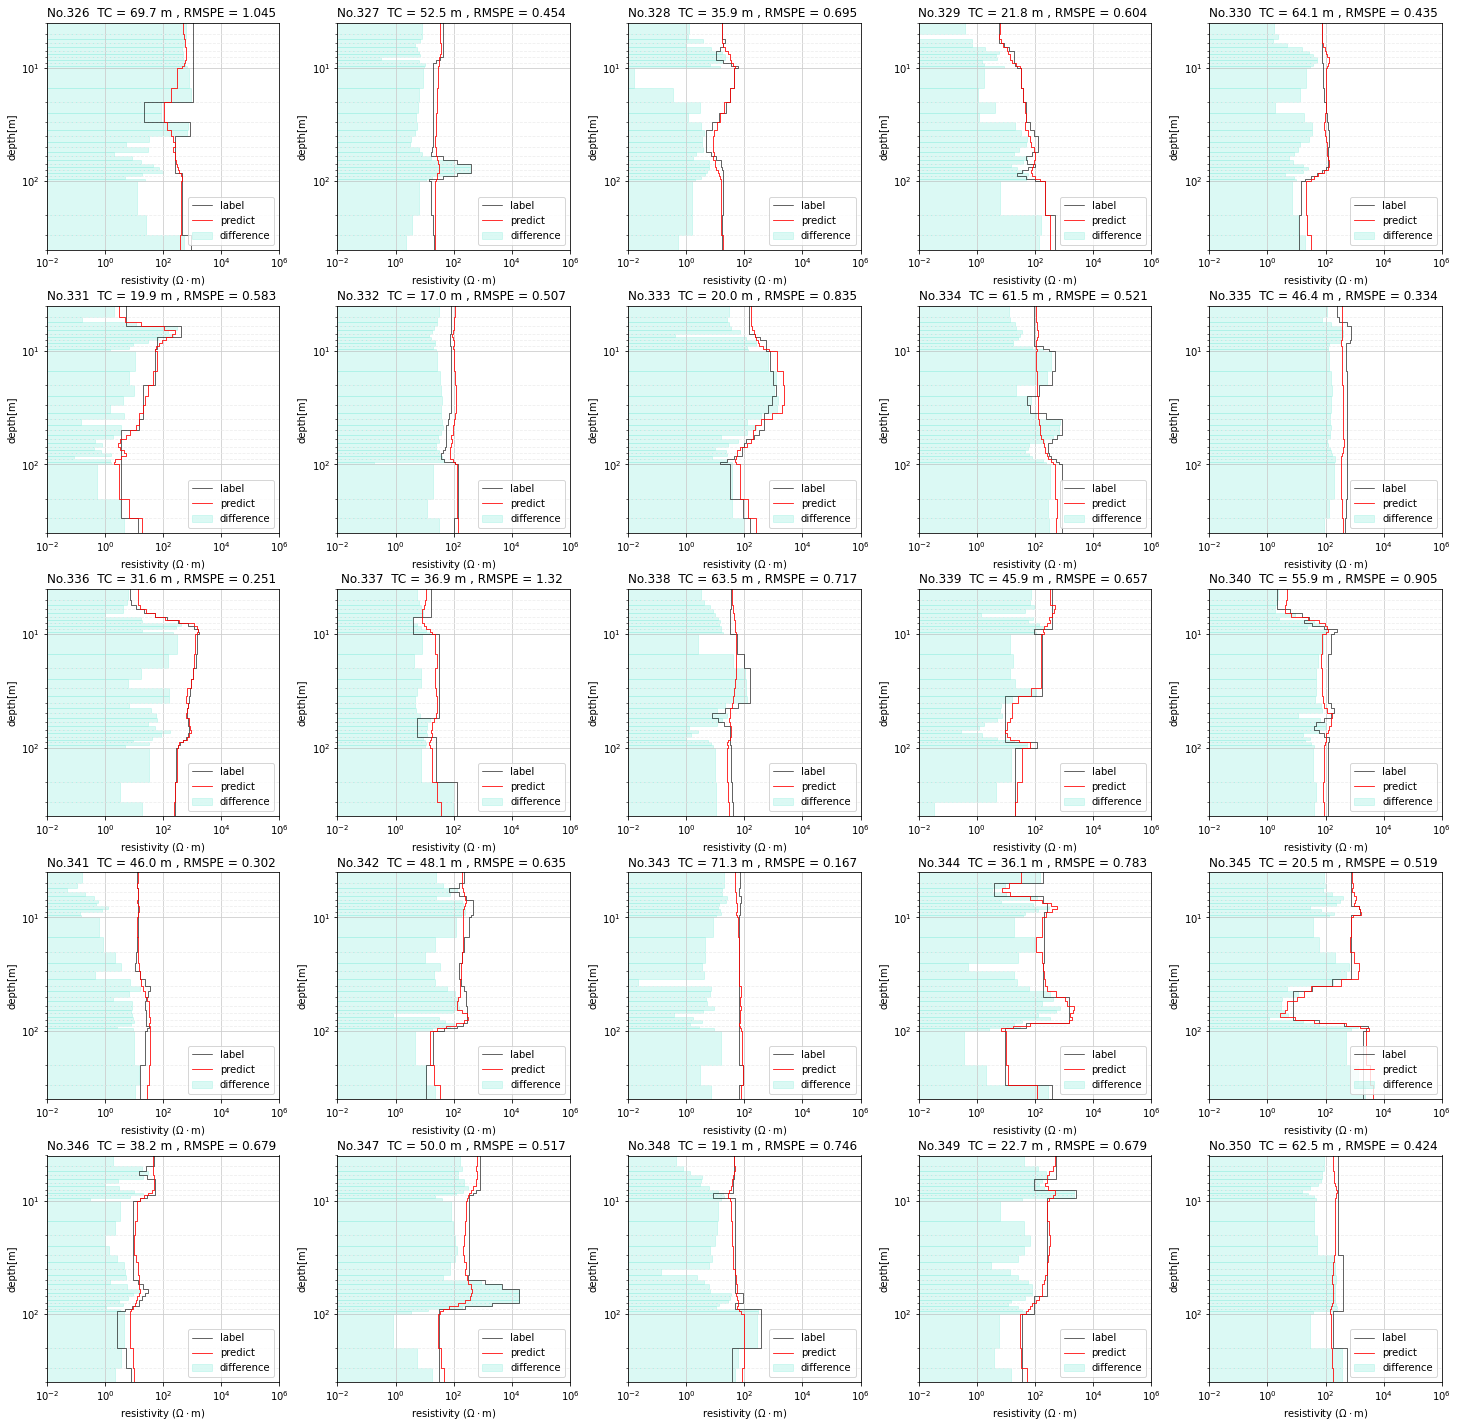

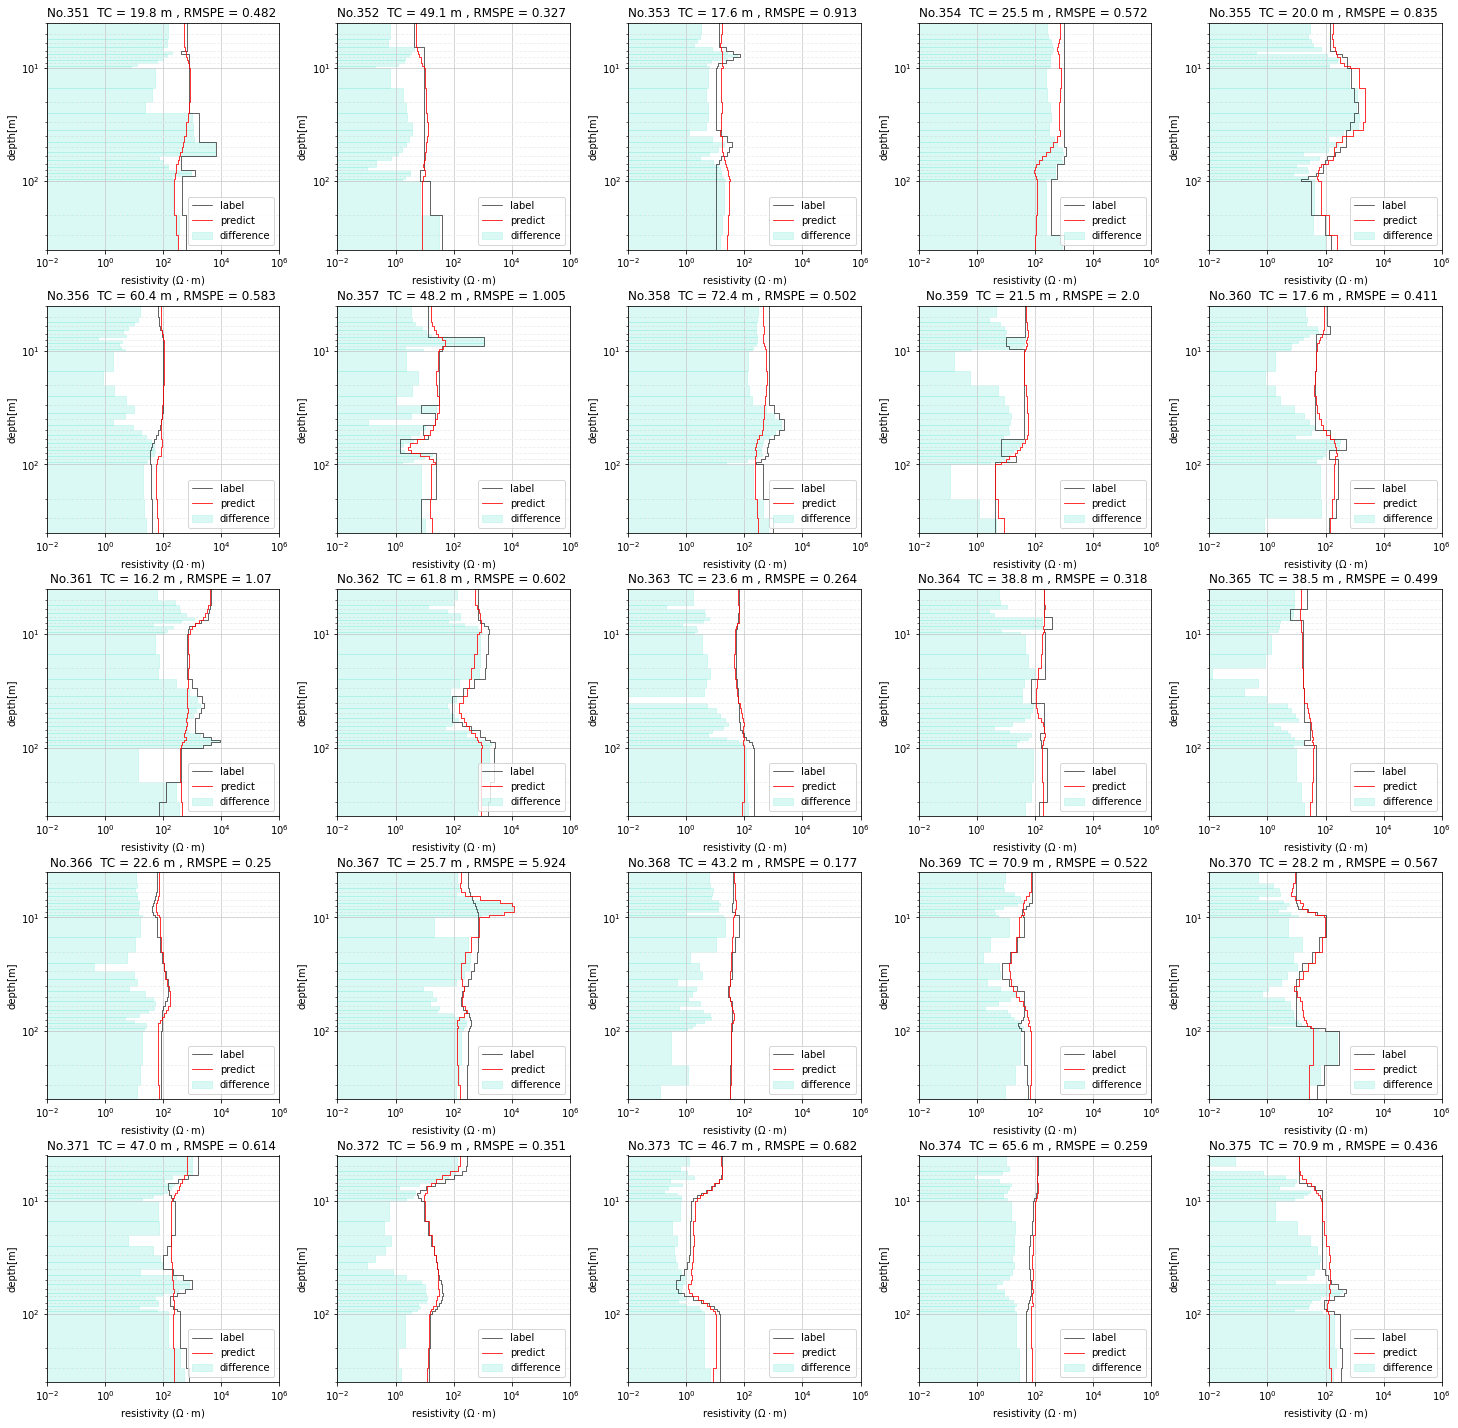

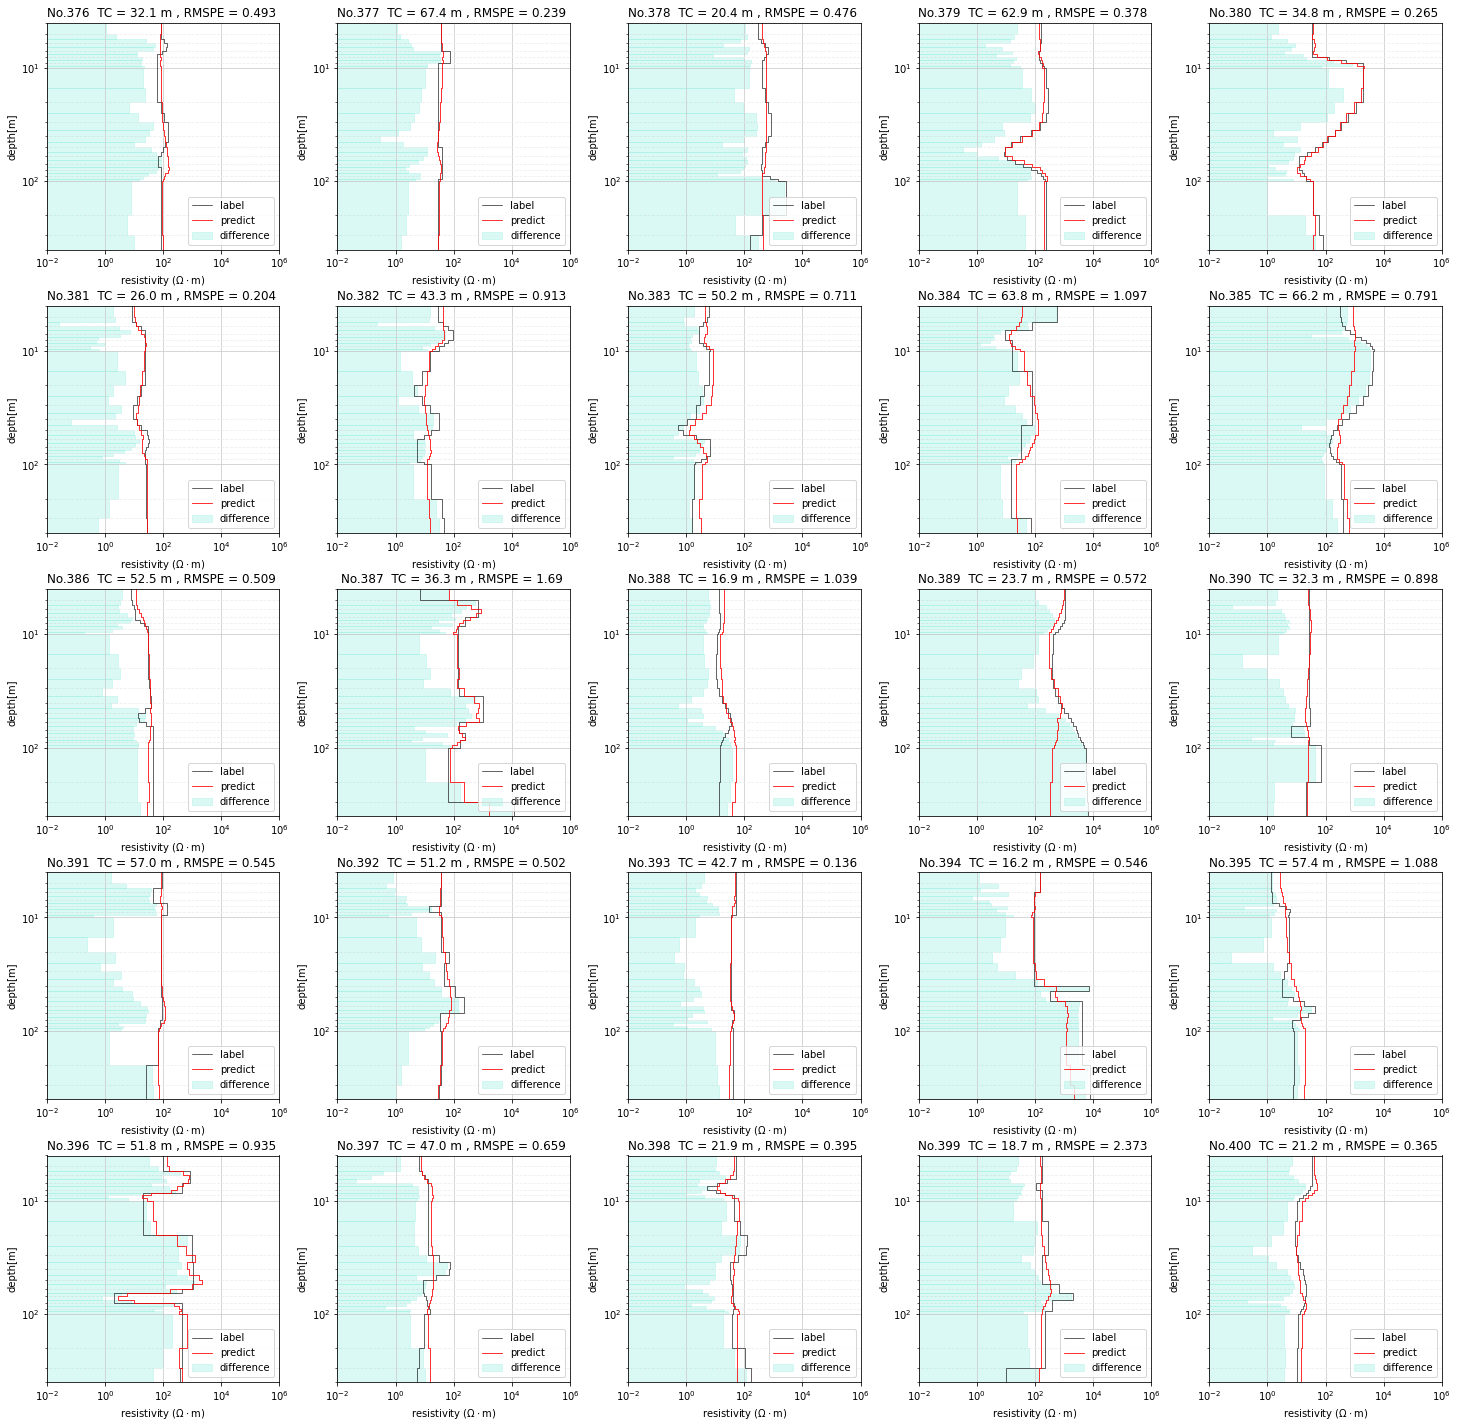

In [12]:
sys.path.append('../../')
from dlxem import myviz as viz

test_data_size = len(y_test)
div25 = test_data_size // 25

for num in range(div25):
    index = np.array([25*num + j for j in range(25)])
    numbers = index + 1

    true_res = 10 ** y_test[index]
    pred_res = 10 ** network.predict(x_test[index])
    height = x_test_org[index, 10]

    fig = viz.resolve.models_poster25(thicks, pred_res, true_res, height, numbers, log_depth=True)